In [1]:
#preliminary setup
# %pip install -r requirements.txt
import numpy as np
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.preprocessing import StandardScaler, MinMaxScaler


#Fetching the data
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split



# set seeds for reproducibility
random_seed = 302
torch.manual_seed(302); np.random.seed(302)

X, y = fetch_california_housing(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.125, random_state=random_seed)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.20, random_state=random_seed, )

Training set
size: (14448, 8)
          MedInc   HouseAge   AveRooms   AveBdrms   Population   AveOccup   Latidue   Longitude
mean        3.86      28.65       5.43        1.1     1421.79        3.13      35.64    -119.58
 std        1.89      12.58       2.41       0.43     1110.97       12.39       2.14       2.01
 min         0.5        1.0       0.85       0.33         6.0        0.69      32.54    -124.35
 max        15.0       52.0     141.91      25.64     35682.0     1243.33      41.95    -114.47


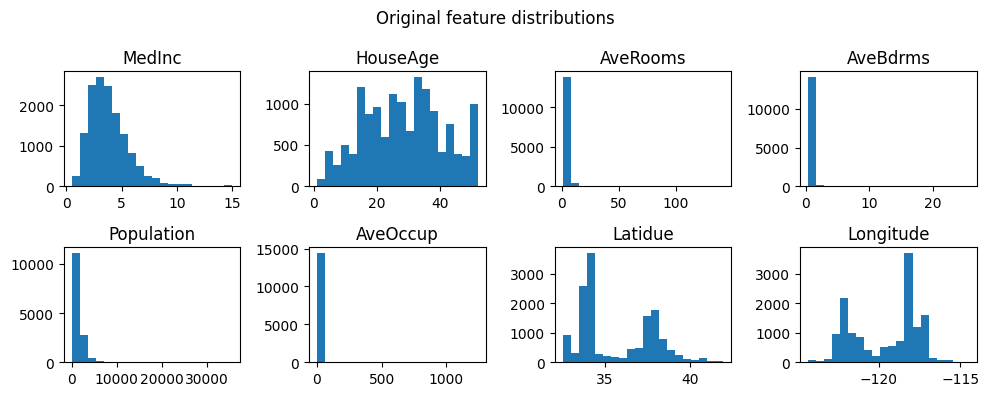

Validation set
size:  (3612, 8)
          MedInc   HouseAge   AveRooms   AveBdrms   Population   AveOccup   Latidue   Longitude
mean        3.89      28.48        5.4       1.09     1431.85        2.93       35.6    -119.54
 std        1.95      12.66       1.82       0.28     1145.46        1.05       2.12       1.98
 min         0.5        1.0       1.38       0.38         3.0        0.75      32.56    -124.25
 max        15.0       52.0      36.48       7.97     15037.0       41.21      41.95    -114.31


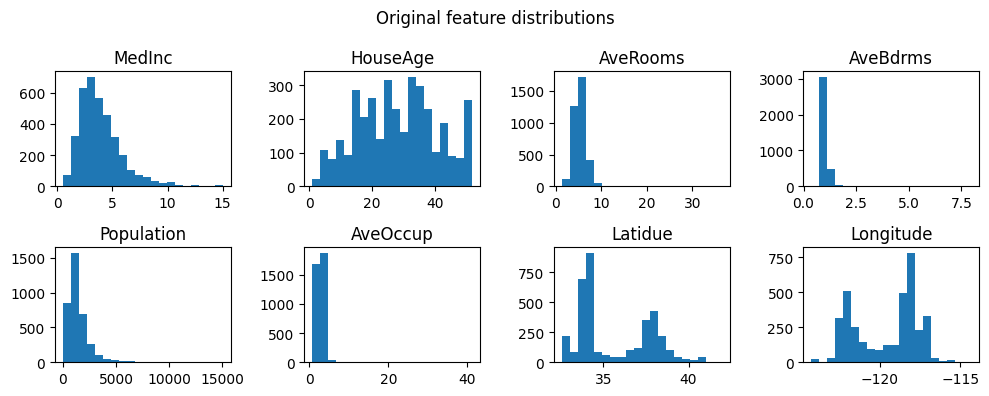

Test set
size:  (2580, 8)
          MedInc   HouseAge   AveRooms   AveBdrms   Population   AveOccup   Latidue   Longitude
mean        3.87      28.77       5.48       1.11     1437.18        2.94      35.62    -119.57
 std         1.9      12.49       3.45        0.8     1228.94        1.29       2.14       1.99
 min         0.5        2.0       0.89        0.5         8.0        1.29      32.55    -124.19
 max        15.0       52.0     132.53      34.07     28566.0        51.4      41.88    -114.49


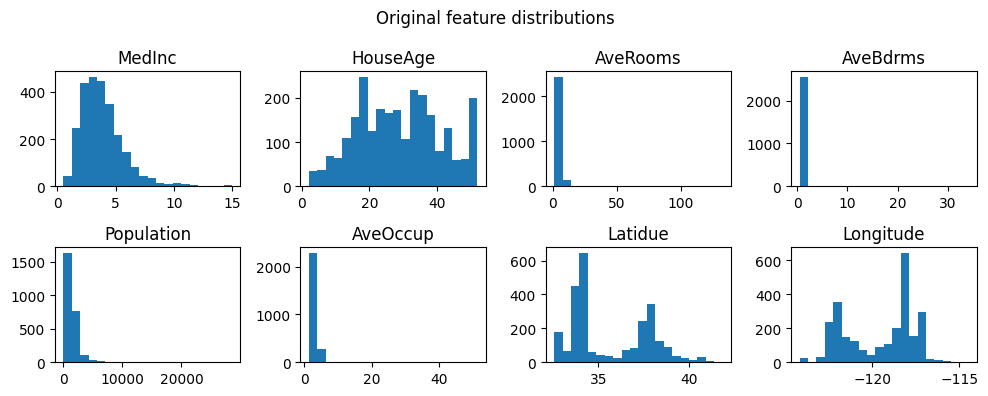

index: 0
index: 2
index: 4
Training set
size: (14448, 8)
          MedInc   HouseAge   AveRooms   AveBdrms   Population   AveOccup   Latidue   Longitude
mean        -0.0       -0.0       -0.0       -0.0        -0.0         0.0        0.0       -0.0
 std         1.0        1.0        1.0        1.0         1.0         1.0        1.0        1.0
 min       -1.78       -2.2       -1.9      -1.76       -1.27        -0.2      -1.45      -2.37
 max         5.9       1.86      56.72      56.66       30.84       100.1       2.95       2.54


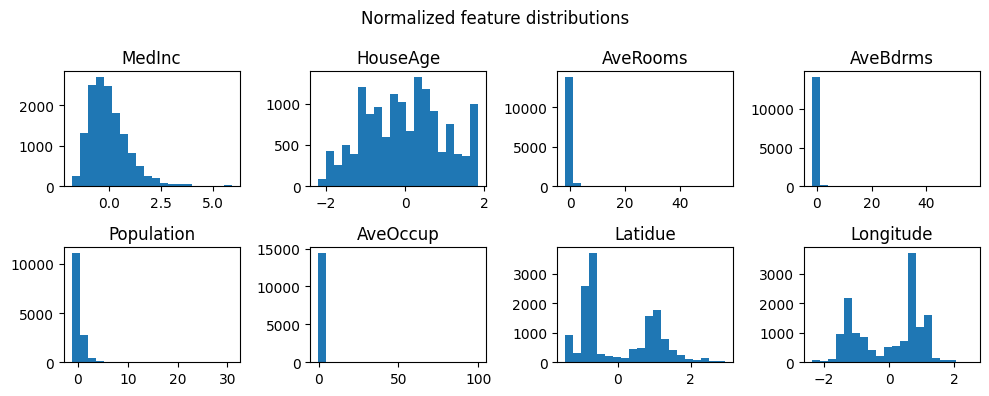

Validation set
size:  (2580, 8)
          MedInc   HouseAge   AveRooms   AveBdrms   Population   AveOccup   Latidue   Longitude
mean        0.01       0.01       0.02       0.03        0.01       -0.02      -0.01        0.0
 std        1.01       0.99       1.43       1.84        1.11         0.1        1.0       0.99
 min       -1.78      -2.12      -1.89      -1.38       -1.27       -0.15      -1.45      -2.29
 max         5.9       1.86      52.82      76.13       24.43         3.9       2.92       2.53


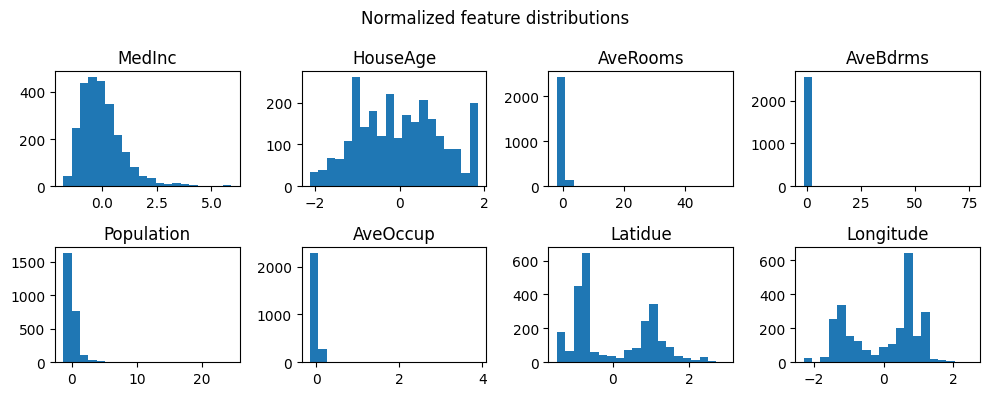

In [2]:
ONLY_TRAINING_SET = False
#a.) Investigating the dataset

all_sets = [X_train,y_train,X_validation,y_validation,X_test,y_test]
all_sets_names = ["Training set","Training targtets","Validation set","Validation targets","Test set","Test targets"]
features = ["MedInc","HouseAge","AveRooms","AveBdrms","Population","AveOccup","Latidue","Longitude"]
if ONLY_TRAINING_SET:
    all_sets = [X_train, y_train]
    all_sets_names = ["Training set","Training targtets"]


#Checking the data, to see what would be good to normalize
for set, name in zip(all_sets[0::2],all_sets_names[0::2]):
    
    print('\033[4m'+'\033[1m'+f"{name}"+'\033[0m'+'\033[0m')
    print(f"size: {str(set.shape) : >10}")
    stats = {"mean":[],
             "std":[],
             "min":[],
             "max":[]}
    fig,axs = plt.subplots(2,len(features)//2,figsize=(10,4),layout = "tight")
    for col,feature in enumerate(features):
        feature_data = set[:,col]
        stats["mean"].append(np.mean(feature_data))
        stats["std"].append(np.std(feature_data))
        stats["min"].append(np.min(feature_data))
        stats["max"].append(np.max(feature_data))
        axs[int(np.floor(col/4))][(col%4)].hist(feature_data,bins=20)
        axs[int(np.floor(col/4))][(col%4)].set_title(feature)
        

    print('\033[1m'+"          "+f"{'   '.join(features)}"+'\033[0m')
    for stat,vals in stats.items():
        x = [str(round(val,2)) for val in vals]
        print('{:>4}{:>12s}{:>11s}{:>11s}{:>11s}{:>12s}{:>12s}{:>11s}{:>11s}'.format(stat,x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7]))
    
    plt.suptitle("Original feature distributions")
    plt.show()
    fig.savefig(f"./plots/{'feature distributions'}.png")

#Normalizing data

#fitting the scalers first on the training set and then applying same scalings to the validation and test set
normalized_sets = []
standard_dist_scaler_1 = StandardScaler()
standard_dist_scaler_1.fit(X_train)
X_train_standard = standard_dist_scaler_1.transform(X_train)

min_max_scaler = MinMaxScaler()
min_max_scaler.fit(X_train_standard)
X_train_standart_minmax = min_max_scaler.transform(X_train_standard)

#do another scaling, so it's centered around 0 again
standard_dist_scaler_2 = StandardScaler()
standard_dist_scaler_2.fit(X_train_standart_minmax)

#TODO: Decide normalization on individual level
# now only applied standardization everywhere

for i,set in enumerate(all_sets[0::2]):
    norm_set = standard_dist_scaler_1.transform(set)
    #norm_set = min_max_scaler.transform(norm_set)
    #norm_set = standard_dist_scaler_2.transform(norm_set)
    print(f"index: {i*2}")
    normalized_sets.append(norm_set)

    # new_set = np.zeros_like(set)
    # for col in range(len(features)):

    #     norm_feature = np.reshape(set[:,col],(1,len(set[:,col])))
        
    #     #Standard gauss distribution
    #     norm_feature = (norm_feature-np.mean(norm_feature))/np.std(norm_feature)
    #     all_sets[i*2][:,col] = norm_feature
        
    #     #min-max scaling into -1 +1 range
    #     norm_feature = (norm_feature-np.min(np.abs(norm_feature)))/(np.max(np.abs(norm_feature))-np.min(np.abs(norm_feature)))
    #     new_set[:,col] = norm_feature

    # normalized_sets.append(new_set)

for i,(set,name) in enumerate(zip(normalized_sets[0::2],all_sets_names[0::2])):
    print('\033[4m'+'\033[1m'+f"{name}"+'\033[0m'+'\033[0m')
    print(f"size: {str(set.shape) : >10}")
    stats = {"mean":[],
                "std":[],
                "min":[],
                "max":[]}
    fig,axs = plt.subplots(2,len(features)//2,figsize=(10,4),layout = "tight")
    for col,feature in enumerate(features):
        feature_data = set[:,col]
        stats["mean"].append(np.mean(feature_data))
        stats["std"].append(np.std(feature_data))
        stats["min"].append(np.min(feature_data))
        stats["max"].append(np.max(feature_data))
        axs[int(np.floor(col/4))][(col%4)].hist(feature_data,bins=20)
        axs[int(np.floor(col/4))][(col%4)].set_title(feature)
        

    print('\033[1m'+"          "+f"{'   '.join(features)}"+'\033[0m')
    for stat,vals in stats.items():
        x = [str(round(val,2)) for val in vals]
        print('{:>4}{:>12s}{:>11s}{:>11s}{:>11s}{:>12s}{:>12s}{:>11s}{:>11s}'.format(stat,x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7]))

    plt.suptitle("Normalized feature distributions")
    plt.show()
    fig.savefig(f"./plots/{'normalized feature distributions'}.png")

## Networks

In [19]:
from models import NeuralNet_deep, NeuralNet_wide, NeuralNet_default, NeuralNet_deep_wider, NeuralNet_deeper_wide

def train_model(model, train_loader, val_loader, device, optimizer=None, num_epochs=50, scheduler=None):
    loss_fn = nn.MSELoss()
    #saves losses on every batch
    train_losses_all = []
    val_losses_all = []
    for epoch in range(num_epochs):
        train_losses_epoch = []
        print('-'*20, f'Epoch {epoch}', '-'*20)
        # Train one epoch
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)

            if optimizer is not None:
                optimizer.zero_grad()
            predict = model(data)
            loss = loss_fn(predict, target)
            loss.backward()
            if optimizer is not None:
                optimizer.step()

            train_losses_epoch.append(loss.item())
        if scheduler is not None:
            scheduler.step() # update learning rate based on the schedule
        train_loss_epoch_mean =np.mean(train_losses_epoch)
        train_losses_all.append(train_loss_epoch_mean)
        print(f'Average Training Loss for epoch(over all batches) {np.mean(train_losses_epoch)}')
        
        # Evaluate on validation set
        model.eval()
        val_loss = 0
        # correct = 0
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                predict = model(data)
                val_loss += F.mse_loss(predict, target, reduction='sum').item()  # sum up batch loss
                # correct += (predict == target).sum().item()

        val_loss /= len(val_loader.dataset)
        # avg_correct = correct / len(val_loader.dataset)
        val_losses_all.append(val_loss)
        # val_accuracies.append(avg_correct)

        print(f'Validation loss for epoch: {val_loss:.4f})\n')
    
    return train_losses_all, val_losses_all


cuda
NeuralNet_deep
-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.7196523288380255
Validation loss for epoch: 0.4259)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.382857851304971
Validation loss for epoch: 0.3901)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.35015719898242864
Validation loss for epoch: 0.3939)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.3281727766173076
Validation loss for epoch: 0.3473)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.31568651356264554
Validation loss for epoch: 0.3250)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.31471759549020667
Validation loss for epoch: 0.3179)

-------------------- Epoch 6 -------------------

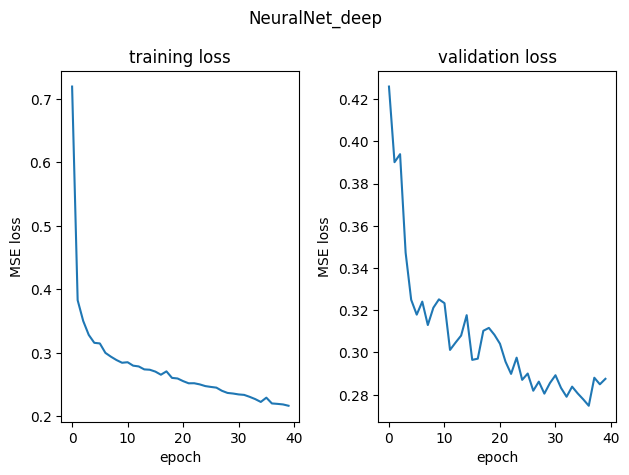

NeuralNet_wide
-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.833409381107287
Validation loss for epoch: 0.4601)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.40431994066235766
Validation loss for epoch: 0.4119)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.3732541203828512
Validation loss for epoch: 0.3821)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.3518041204496295
Validation loss for epoch: 0.3651)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.35549602428434696
Validation loss for epoch: 0.3532)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.3233625863769413
Validation loss for epoch: 0.3570)

-------------------- Epoch 6 --------------------
Aver

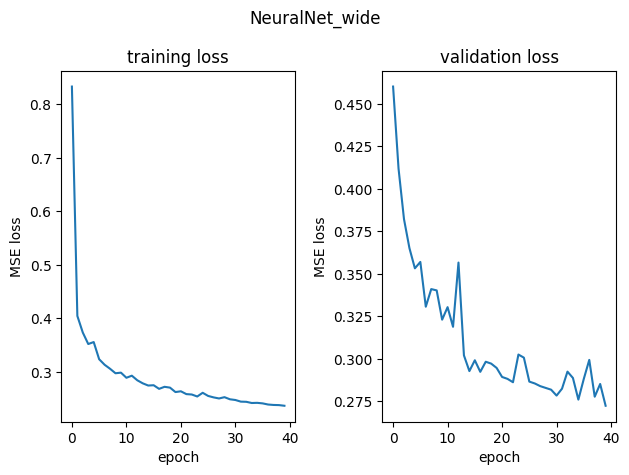

NeuralNet_default
-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.8550614991381896
Validation loss for epoch: 0.4490)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.4093553060418473
Validation loss for epoch: 0.4062)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.3761073505522403
Validation loss for epoch: 0.3928)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.3607732223890788
Validation loss for epoch: 0.3790)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.3505881876577582
Validation loss for epoch: 0.3637)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.34234690638176635
Validation loss for epoch: 0.3475)

-------------------- Epoch 6 --------------------
A

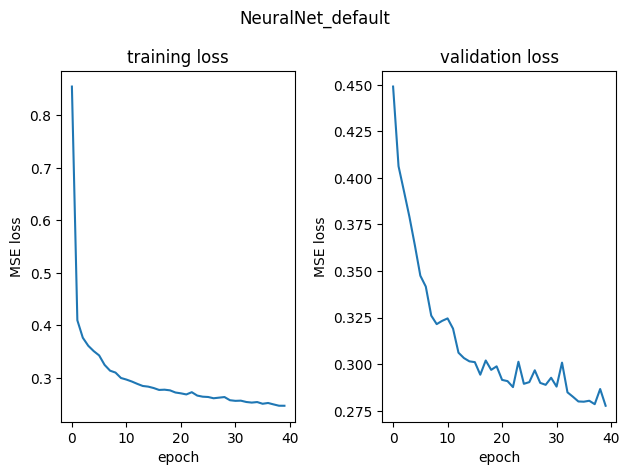

NeuralNet_deep_wider
-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 1.028009366870454
Validation loss for epoch: 0.4261)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.37296304101767264
Validation loss for epoch: 0.3862)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.34196956790324334
Validation loss for epoch: 0.3783)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.3330065067857504
Validation loss for epoch: 0.3372)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.31912731684216883
Validation loss for epoch: 0.3741)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.30690493729723767
Validation loss for epoch: 0.3240)

-------------------- Epoch 6 -----------------

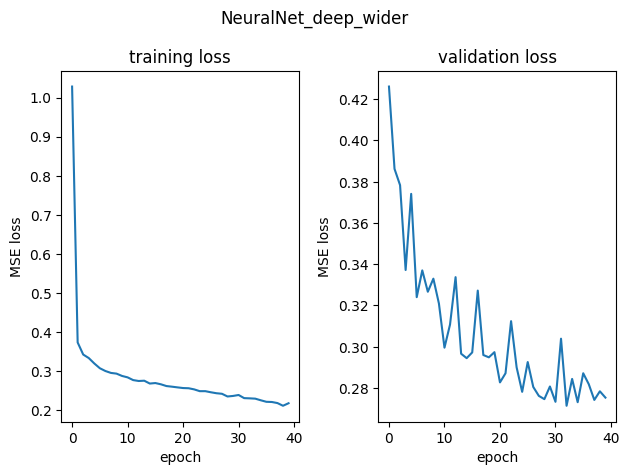

NeuralNet_deeper_wide
-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.6826938451061734
Validation loss for epoch: 0.4654)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.37951479047800585
Validation loss for epoch: 0.3695)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.35088516695968874
Validation loss for epoch: 0.3725)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.3311472881618327
Validation loss for epoch: 0.3345)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.31656390243926935
Validation loss for epoch: 0.3241)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.30719772897726666
Validation loss for epoch: 0.3277)

-------------------- Epoch 6 ---------------

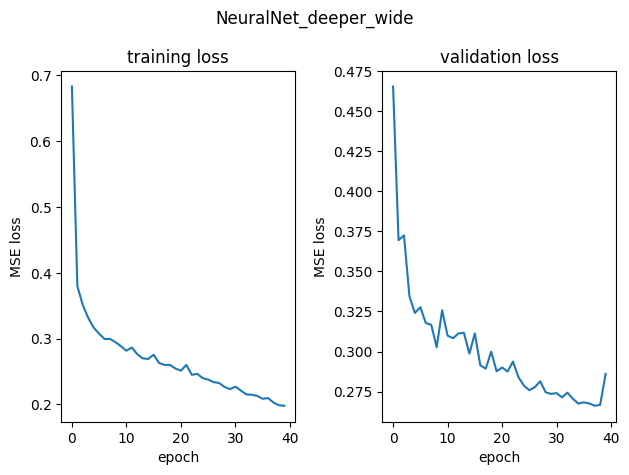

In [4]:
#evaluation of the different models
X_train_norm = normalized_sets[0]
X_val_norm = normalized_sets[1]
X_test_norm = normalized_sets[2]

X_train_torch = torch.tensor(X_train_norm,dtype=torch.float32)
y_train_torch = torch.tensor(y_train.reshape((len(y_train),1)),dtype=torch.float32)
X_validation_torch = torch.tensor(X_val_norm,dtype=torch.float32)
y_validation_torch = torch.tensor(y_validation.reshape((len(y_validation),1)),dtype=torch.float32)

train_dataset = torch.utils.data.TensorDataset(X_train_torch,y_train_torch)
validation_dataset = torch.utils.data.TensorDataset(X_validation_torch,y_validation_torch)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=32, shuffle=True)

device = 'cuda' if torch.cuda.is_available() else 'cpu' # if you have a gpu, you can move the model onto it like this
print(device)
all_models = NeuralNet_deep(), NeuralNet_wide(), NeuralNet_default(), NeuralNet_deep_wider(), NeuralNet_deeper_wide()


for model in all_models:
    print(model._get_name())
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    train_loss, val_loss = train_model(model,train_loader,val_loader,device, optimizer=optimizer, num_epochs=40)

    fig,axs = plt.subplots(1,2,layout="tight")
    axs[0].plot(train_loss)
    axs[0].set_title("training loss")
    # axs[0].set_ylim([max(train_loss),max(train_loss)])
    axs[0].set_xlabel("epoch")
    axs[0].set_ylabel("MSE loss")
    
    axs[1].plot(val_loss)
    axs[1].set_title("validation loss")
    # axs[1].set_ylim([max(val_loss),max(val_loss)])
    axs[1].set_xlabel("epoch")
    axs[1].set_ylabel("MSE loss")
    plt.suptitle(f"{model._get_name()}")
    plt.show()

## c) Optimizers and Scheduling

Optimizer: SGD with learning rate: 0.001 and scheduler: StepLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 2.02623569971956
Validation loss for epoch: 0.8735)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.6954713414991851
Validation loss for epoch: 0.6389)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.6046160638200498
Validation loss for epoch: 0.5985)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.5708450227316502
Validation loss for epoch: 0.5722)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.5456863429759984
Validation loss for epoch: 0.5511)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.5238708470643094
Validation loss for epoch: 0.5329)

-------

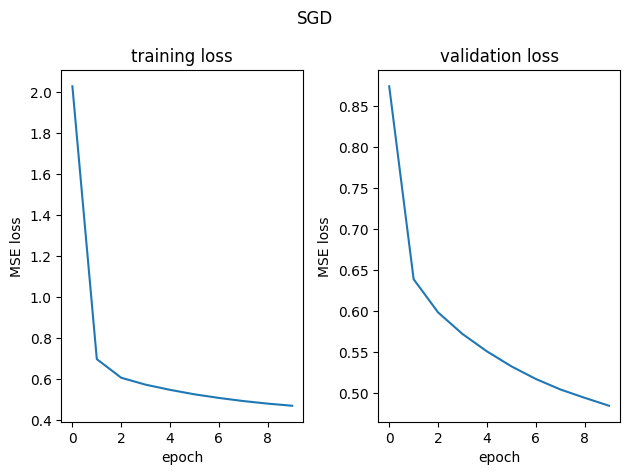

Optimizer: SGD with learning rate: 0.001 and scheduler: MultiStepLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 1.91586039347195
Validation loss for epoch: 0.8468)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.7257804413021138
Validation loss for epoch: 0.6781)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.6382144387910323
Validation loss for epoch: 0.6296)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.5956483376500881
Validation loss for epoch: 0.5930)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.5612868385109226
Validation loss for epoch: 0.5629)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.5386585170914114
Validation loss for epoch: 0.5499)

--

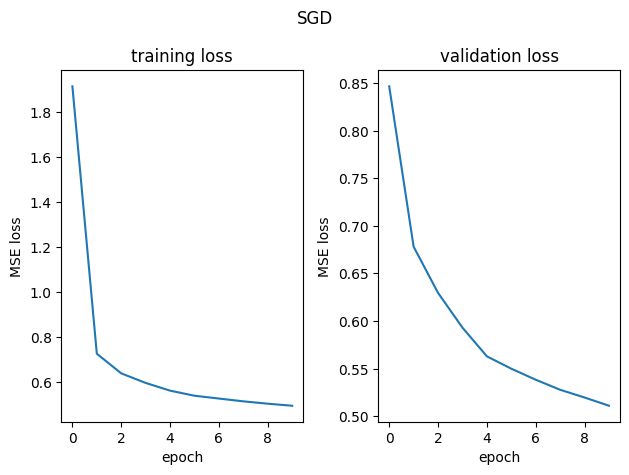

Optimizer: SGD with learning rate: 0.001 and scheduler: CosineAnnealingLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 1.9813018575706314
Validation loss for epoch: 0.9402)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.8145131747345481
Validation loss for epoch: 0.6939)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.6539756508659472
Validation loss for epoch: 0.6461)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.6163844966980736
Validation loss for epoch: 0.6167)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.5870502446407238
Validation loss for epoch: 0.5922)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.5616152027077908
Validation loss for epoch: 0.5

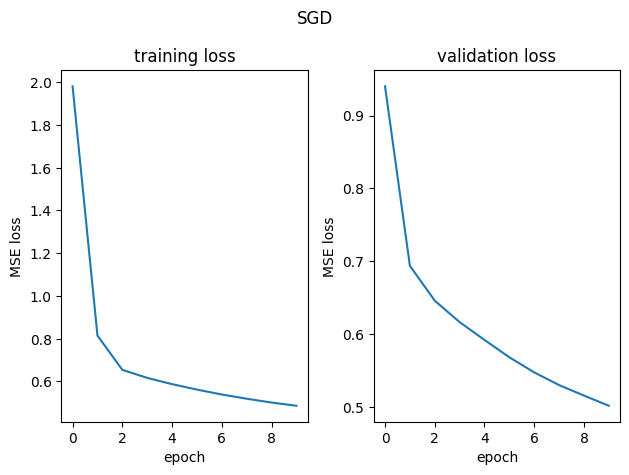

Optimizer: SGD with learning rate: 0.001 and scheduler: CosineAnnealingWarmRestarts 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 2.281735250775793
Validation loss for epoch: 0.9894)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.7643263415161488
Validation loss for epoch: 0.6579)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.6124342076018848
Validation loss for epoch: 0.6024)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.572611944568632
Validation loss for epoch: 0.5741)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.5473397592395808
Validation loss for epoch: 0.5551)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.5310306955227809
Validation loss for ep

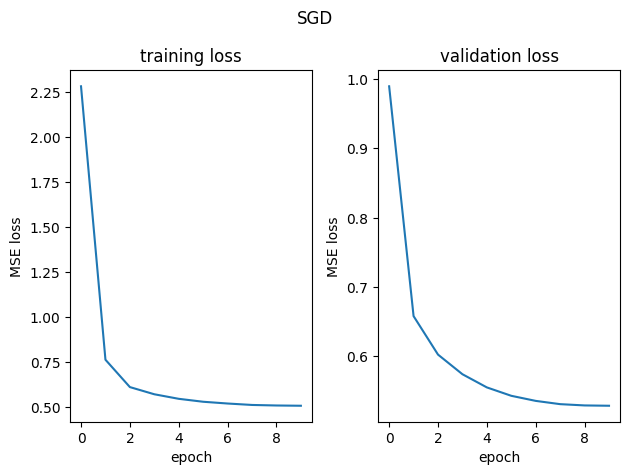

Optimizer: SGD with Momentum with learning rate: 0.001 and scheduler: StepLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.8574286871383675
Validation loss for epoch: 0.5203)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.45778321530834765
Validation loss for epoch: 0.4552)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.41335575689718257
Validation loss for epoch: 0.4325)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.3891072960125398
Validation loss for epoch: 0.4097)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.3709161630543196
Validation loss for epoch: 0.3907)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.3569865158503562
Validation loss for epoch

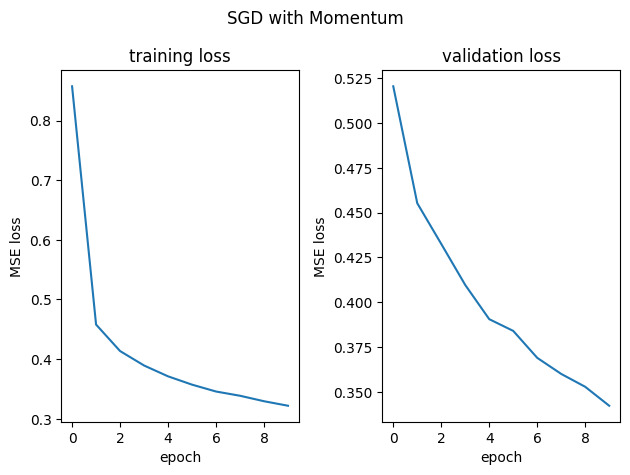

Optimizer: SGD with Momentum with learning rate: 0.001 and scheduler: MultiStepLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.7806352673312732
Validation loss for epoch: 0.4986)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.43905135430395603
Validation loss for epoch: 0.4425)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.4030845719430826
Validation loss for epoch: 0.4147)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.38339243913316623
Validation loss for epoch: 0.4068)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.36900094317981097
Validation loss for epoch: 0.3883)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.3517747222717884
Validation loss for

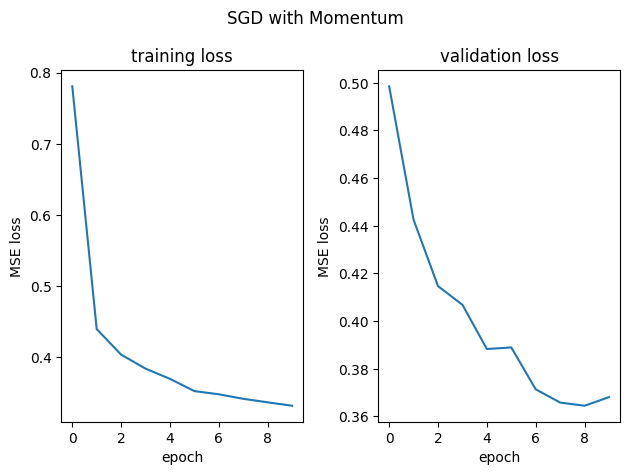

Optimizer: SGD with Momentum with learning rate: 0.001 and scheduler: CosineAnnealingLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.8346573895717089
Validation loss for epoch: 0.4952)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.439971844393727
Validation loss for epoch: 0.4401)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.40121893716596924
Validation loss for epoch: 0.4408)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.38096862774243395
Validation loss for epoch: 0.3974)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.36715669000307016
Validation loss for epoch: 0.3857)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.3566618172237567
Validation los

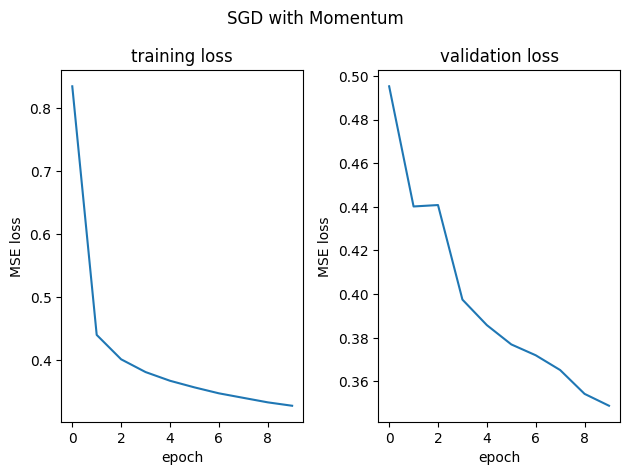

Optimizer: SGD with Momentum with learning rate: 0.001 and scheduler: CosineAnnealingWarmRestarts 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.8094389359837613
Validation loss for epoch: 0.5094)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.4445433347955742
Validation loss for epoch: 0.4419)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.4000201766766542
Validation loss for epoch: 0.4314)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.3822010787681932
Validation loss for epoch: 0.4111)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.3678859950133921
Validation loss for epoch: 0.3862)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.35732094447367485
Valid

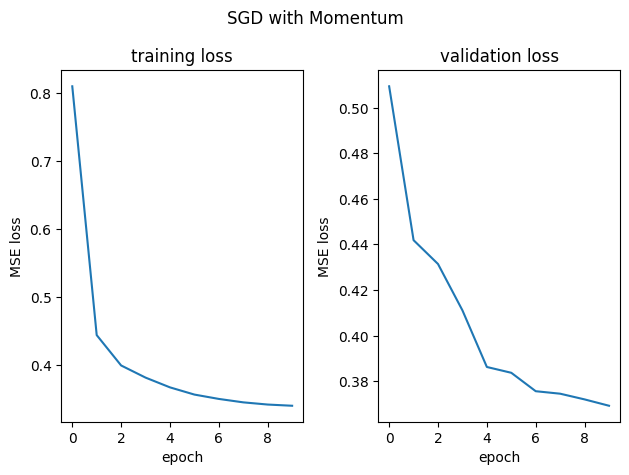

Optimizer: Nesterov SGD with Momentum with learning rate: 0.001 and scheduler: StepLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.7817957258527786
Validation loss for epoch: 0.4972)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.44727598748837427
Validation loss for epoch: 0.4505)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.4101889002573701
Validation loss for epoch: 0.4236)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.3893789485080448
Validation loss for epoch: 0.4054)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.3705534769502361
Validation loss for epoch: 0.3876)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.3591135430883254
Validation loss f

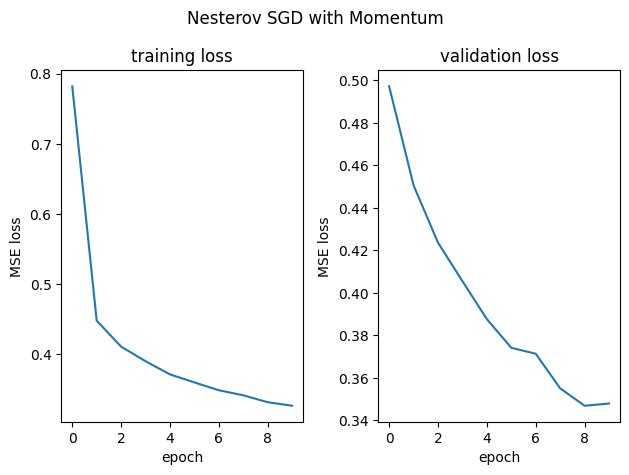

Optimizer: Nesterov SGD with Momentum with learning rate: 0.001 and scheduler: MultiStepLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.8105135302891774
Validation loss for epoch: 0.5006)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.4398884011383078
Validation loss for epoch: 0.4455)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.40304918156986214
Validation loss for epoch: 0.4147)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.3801578390947749
Validation loss for epoch: 0.4162)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.3655564011264164
Validation loss for epoch: 0.4090)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.3490179596155618
Validation l

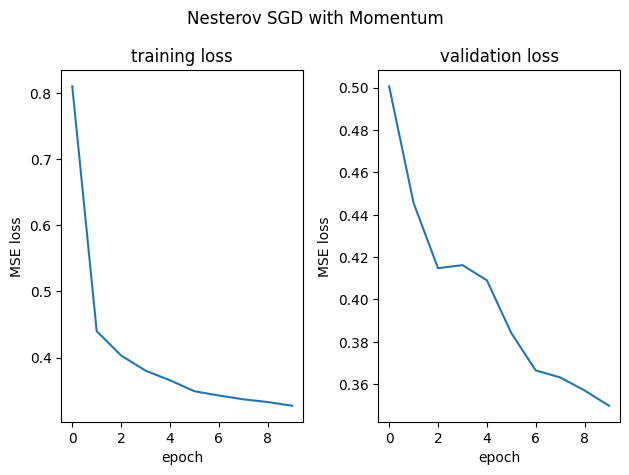

Optimizer: Nesterov SGD with Momentum with learning rate: 0.001 and scheduler: CosineAnnealingLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.7975403451550324
Validation loss for epoch: 0.5223)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.4576320168191353
Validation loss for epoch: 0.4490)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.41292430389573614
Validation loss for epoch: 0.4275)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.38934917769403055
Validation loss for epoch: 0.4160)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.37222808156063597
Validation loss for epoch: 0.3986)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.3588926603242887
Vali

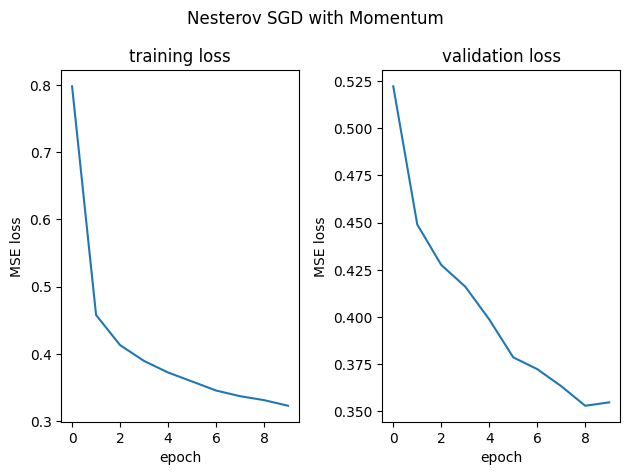

Optimizer: Nesterov SGD with Momentum with learning rate: 0.001 and scheduler: CosineAnnealingWarmRestarts 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.8167774168593166
Validation loss for epoch: 0.5046)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.44178280900273703
Validation loss for epoch: 0.4528)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.39661285811952784
Validation loss for epoch: 0.4147)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.37376504734290383
Validation loss for epoch: 0.3968)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.3581311138989651
Validation loss for epoch: 0.3822)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.34843425226

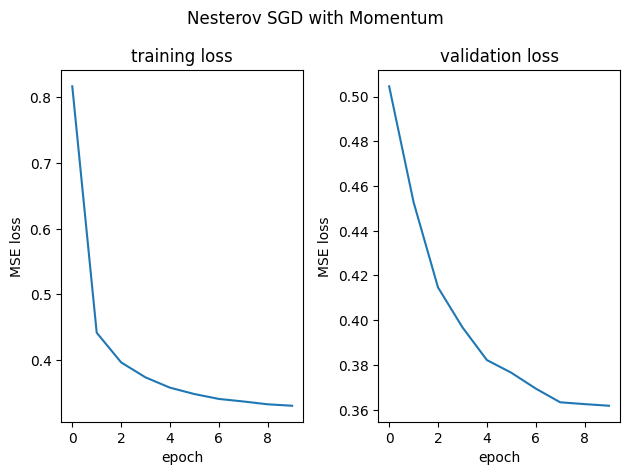

Optimizer: RMSProp with learning rate: 0.001 and scheduler: StepLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.48798314125928205
Validation loss for epoch: 0.4523)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.37974516424325716
Validation loss for epoch: 0.3907)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.35428525649208936
Validation loss for epoch: 0.3616)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.3316958639770746
Validation loss for epoch: 0.3474)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.32296191894375115
Validation loss for epoch: 0.3490)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.30917386115586337
Validation loss for epoch: 0.331

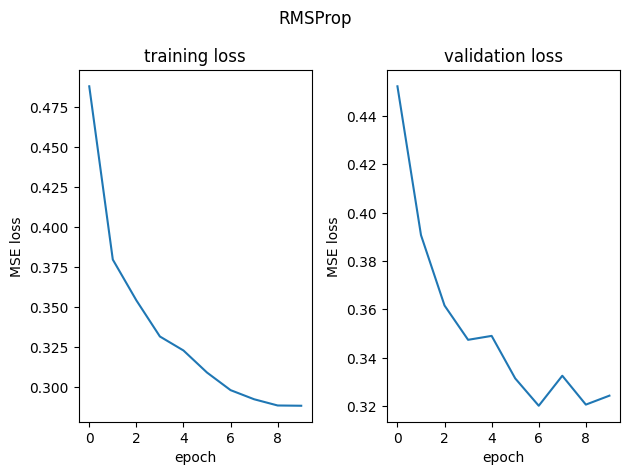

Optimizer: RMSProp with learning rate: 0.001 and scheduler: MultiStepLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.5247091530962328
Validation loss for epoch: 0.7395)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.390559448094099
Validation loss for epoch: 0.3942)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.3548710151385944
Validation loss for epoch: 0.4027)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.33291989678632367
Validation loss for epoch: 0.3555)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.3169749304322542
Validation loss for epoch: 0.3379)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.28722521900075726
Validation loss for epoch: 0.31

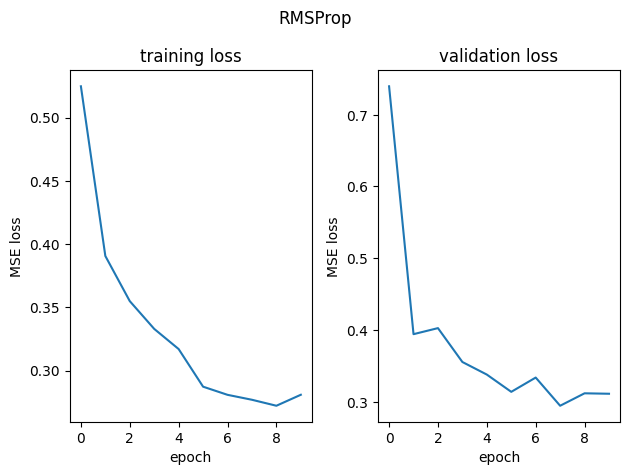

Optimizer: RMSProp with learning rate: 0.001 and scheduler: CosineAnnealingLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.6999118206280787
Validation loss for epoch: 0.4344)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.390141499088665
Validation loss for epoch: 0.4322)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.35929166950878844
Validation loss for epoch: 0.3673)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.3411636451110903
Validation loss for epoch: 0.3391)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.321295297943649
Validation loss for epoch: 0.3423)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.3125446882857158
Validation loss for epoch: 

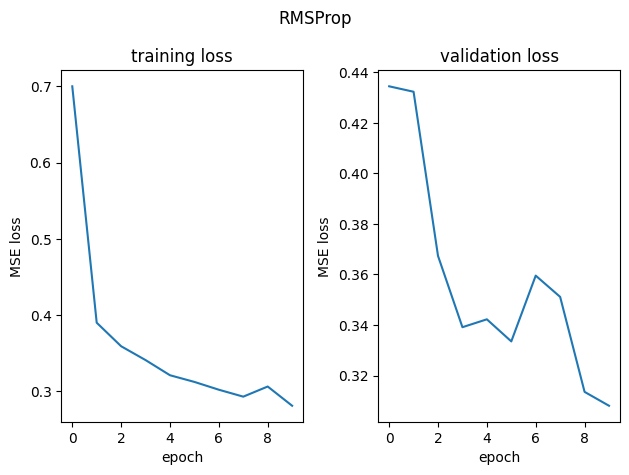

Optimizer: RMSProp with learning rate: 0.001 and scheduler: CosineAnnealingWarmRestarts 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.4984862676994727
Validation loss for epoch: 0.4437)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.36785945827058986
Validation loss for epoch: 0.4163)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.3420165169951135
Validation loss for epoch: 0.3454)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.3174528537433496
Validation loss for epoch: 0.3313)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.30026774060607486
Validation loss for epoch: 0.3191)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.28735788885207303
Validation lo

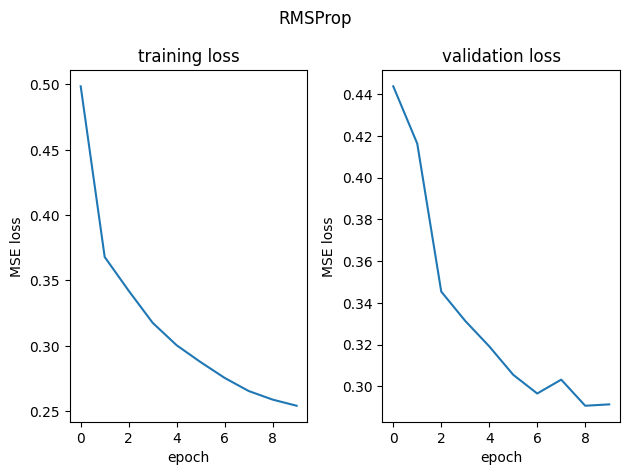

Optimizer: Adam with learning rate: 0.001 and scheduler: StepLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.605000363184815
Validation loss for epoch: 0.3920)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.37727786203335345
Validation loss for epoch: 0.3892)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.3480936431581468
Validation loss for epoch: 0.3488)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.3362739266481547
Validation loss for epoch: 0.3333)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.3129680287422596
Validation loss for epoch: 0.3358)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.306648438120574
Validation loss for epoch: 0.3131)

-----

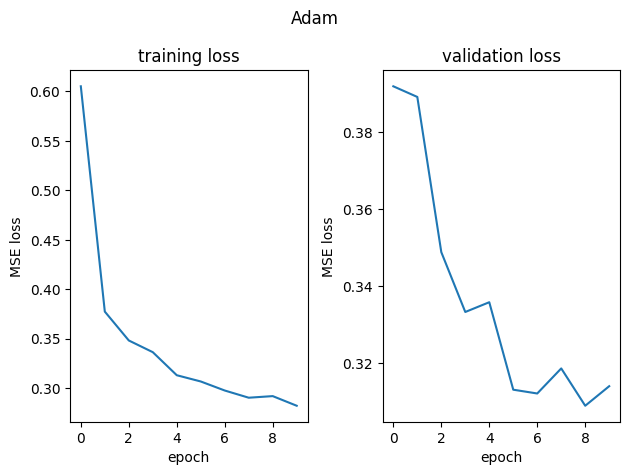

Optimizer: Adam with learning rate: 0.001 and scheduler: MultiStepLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.5736469979834767
Validation loss for epoch: 0.4680)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.3744164825112155
Validation loss for epoch: 0.5091)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.34898209077330816
Validation loss for epoch: 0.3468)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.3342149338099809
Validation loss for epoch: 0.3389)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.32112765516591285
Validation loss for epoch: 0.3270)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.2952352912552589
Validation loss for epoch: 0.3121

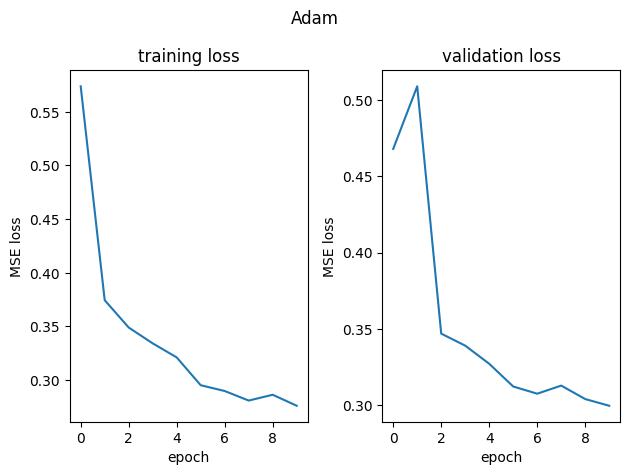

Optimizer: Adam with learning rate: 0.001 and scheduler: CosineAnnealingLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.5730594301645735
Validation loss for epoch: 0.4281)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.38865006741433017
Validation loss for epoch: 0.3738)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.34282690794330783
Validation loss for epoch: 0.3653)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.32473529115385186
Validation loss for epoch: 0.3235)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.31109068119090744
Validation loss for epoch: 0.3271)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.3107997884363991
Validation loss for epoch

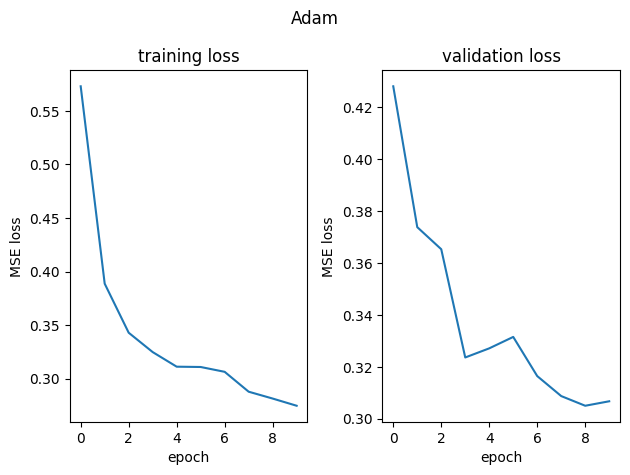

Optimizer: Adam with learning rate: 0.001 and scheduler: CosineAnnealingWarmRestarts 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.5707267848362702
Validation loss for epoch: 0.3926)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.37999005589337476
Validation loss for epoch: 0.4086)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.34655462278761956
Validation loss for epoch: 0.3623)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.3226897180311184
Validation loss for epoch: 0.3267)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.306931205357598
Validation loss for epoch: 0.3276)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.296232276752723
Validation loss for

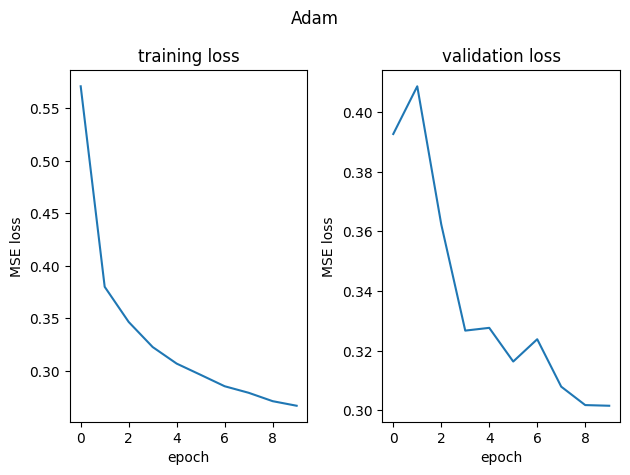

Optimizer: SGD with learning rate: 0.005 and scheduler: StepLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.8940269394851892
Validation loss for epoch: 0.5621)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.4885644874148137
Validation loss for epoch: 0.4857)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.437590477823288
Validation loss for epoch: 0.4545)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.41208800356999964
Validation loss for epoch: 0.4327)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.39480157573995867
Validation loss for epoch: 0.4170)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.3831463235933169
Validation loss for epoch: 0.4041)

----

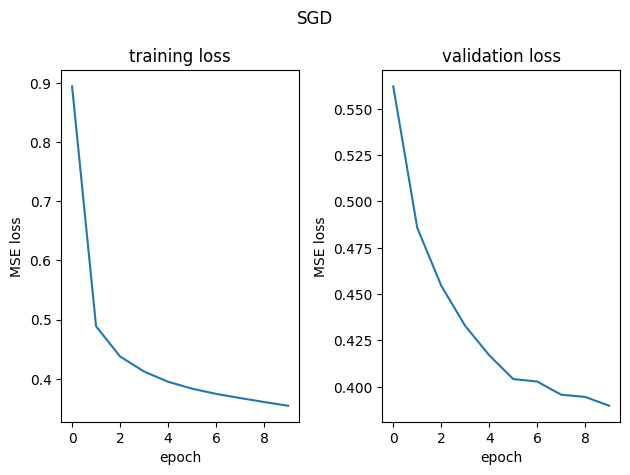

Optimizer: SGD with learning rate: 0.005 and scheduler: MultiStepLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.9824788683481449
Validation loss for epoch: 0.5526)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.4938863603216884
Validation loss for epoch: 0.4930)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.43797247393666644
Validation loss for epoch: 0.4471)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.4099601689989852
Validation loss for epoch: 0.4282)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.39328743800916505
Validation loss for epoch: 0.4156)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.3805119221354217
Validation loss for epoch: 0.4111)

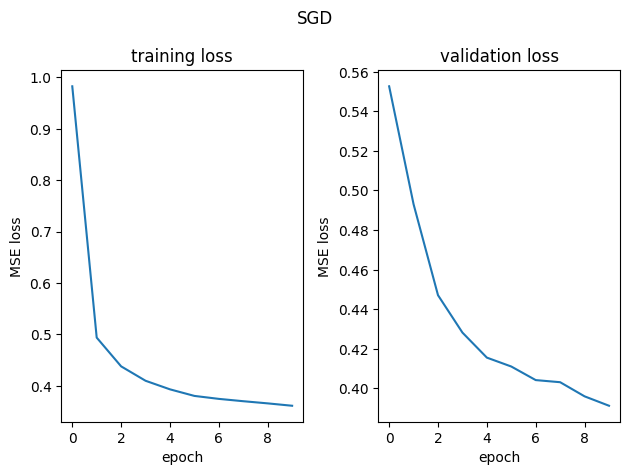

Optimizer: SGD with learning rate: 0.005 and scheduler: CosineAnnealingLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.8474025899066334
Validation loss for epoch: 0.5533)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.48499072372781493
Validation loss for epoch: 0.4789)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.4367934093044131
Validation loss for epoch: 0.4511)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.4128136555375779
Validation loss for epoch: 0.4325)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.3975876457659544
Validation loss for epoch: 0.4246)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.38425454985251467
Validation loss for epoch: 0

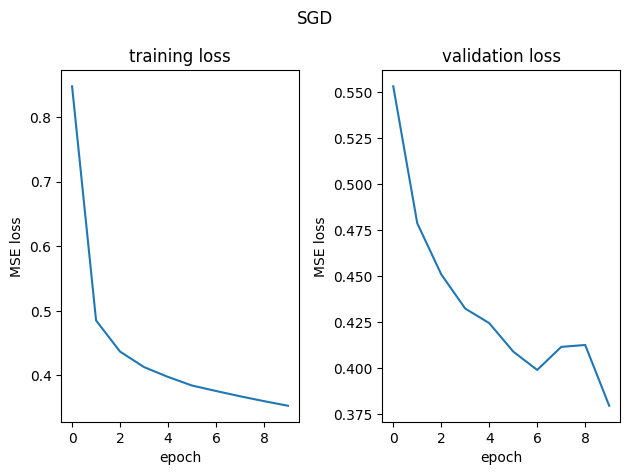

Optimizer: SGD with learning rate: 0.005 and scheduler: CosineAnnealingWarmRestarts 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.8932950116891777
Validation loss for epoch: 0.5638)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.49784600846799076
Validation loss for epoch: 0.4947)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.44253053351313665
Validation loss for epoch: 0.4531)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.4159681884060919
Validation loss for epoch: 0.4423)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.40222558257194746
Validation loss for epoch: 0.4284)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.39267371357542225
Validation loss 

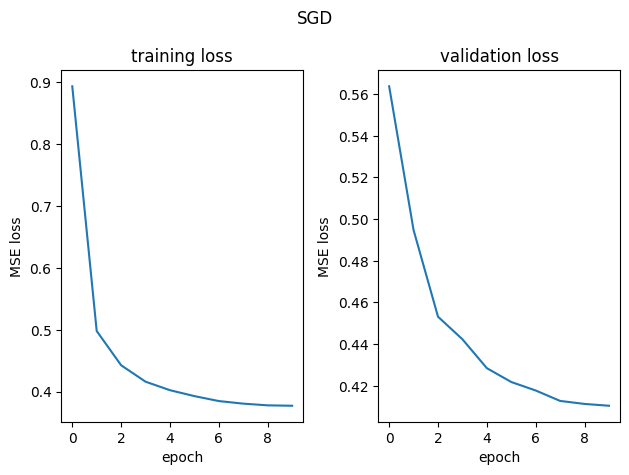

Optimizer: SGD with Momentum with learning rate: 0.005 and scheduler: StepLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.5881276968042407
Validation loss for epoch: 0.4174)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.3853422040037349
Validation loss for epoch: 0.3850)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.36523214711156565
Validation loss for epoch: 0.3748)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.35632895370038736
Validation loss for epoch: 0.4167)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.3451640791696521
Validation loss for epoch: 0.3468)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.3237425129596902
Validation loss for epoch

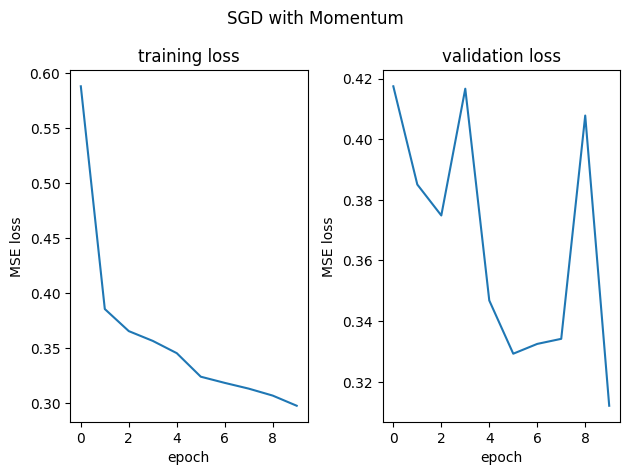

Optimizer: SGD with Momentum with learning rate: 0.005 and scheduler: MultiStepLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.6006809173695808
Validation loss for epoch: 0.4308)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.3987831025986017
Validation loss for epoch: 0.3887)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.3668571500915342
Validation loss for epoch: 0.3754)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.347113589467728
Validation loss for epoch: 0.3718)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.3334133843273188
Validation loss for epoch: 0.3303)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.3053983925487352
Validation loss for epo

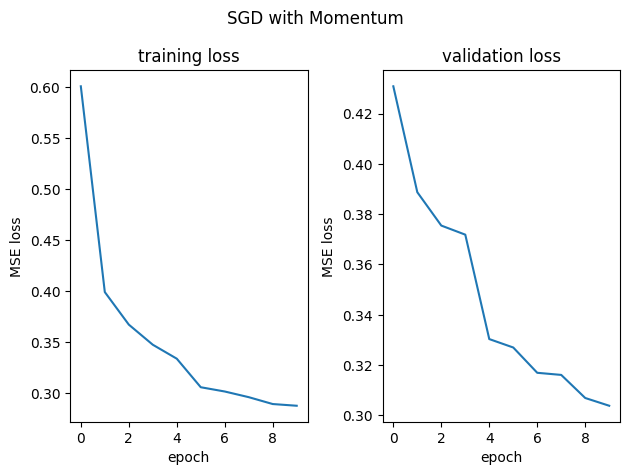

Optimizer: SGD with Momentum with learning rate: 0.005 and scheduler: CosineAnnealingLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.8959414311313787
Validation loss for epoch: 0.4956)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.4267517841231506
Validation loss for epoch: 0.4116)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.38675862252382576
Validation loss for epoch: 0.4116)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.3555929641840996
Validation loss for epoch: 0.3705)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.3420499586294183
Validation loss for epoch: 0.3610)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.3326914804798048
Validation loss

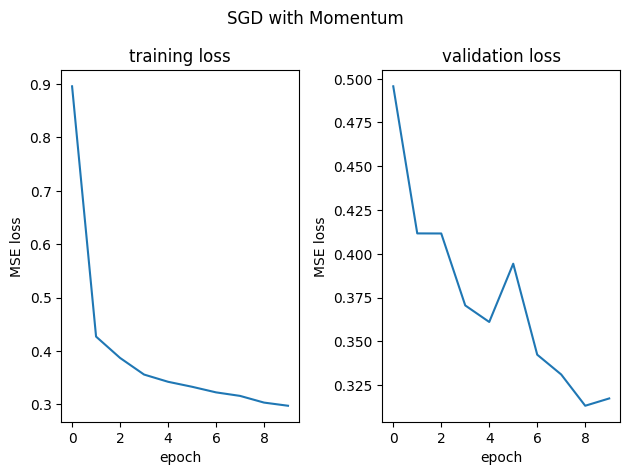

Optimizer: SGD with Momentum with learning rate: 0.005 and scheduler: CosineAnnealingWarmRestarts 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.6683928601905308
Validation loss for epoch: 0.4441)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.41308449845002815
Validation loss for epoch: 0.4024)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.37171435067677394
Validation loss for epoch: 0.3993)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.34540163311876554
Validation loss for epoch: 0.3491)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.32518859548840373
Validation loss for epoch: 0.3754)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.3132398720270237
Va

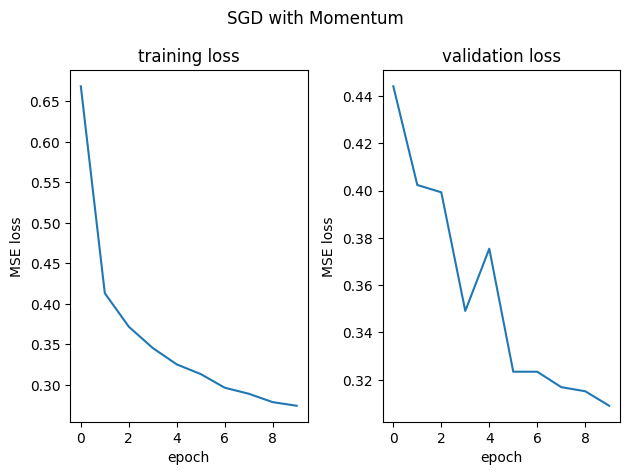

Optimizer: Nesterov SGD with Momentum with learning rate: 0.005 and scheduler: StepLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.5856035979448166
Validation loss for epoch: 0.4475)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.3841125965777752
Validation loss for epoch: 0.3891)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.35686384574963453
Validation loss for epoch: 0.3648)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.3407679797702395
Validation loss for epoch: 0.3589)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.32328857919943016
Validation loss for epoch: 0.3318)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.31270813683163273
Validation loss

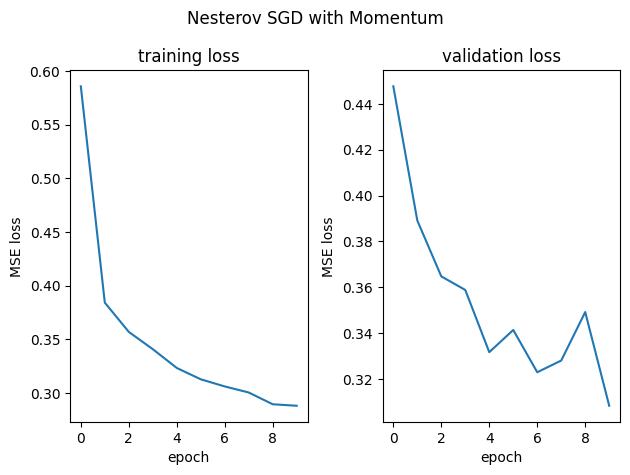

Optimizer: Nesterov SGD with Momentum with learning rate: 0.005 and scheduler: MultiStepLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.560375900658886
Validation loss for epoch: 0.4357)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.38774783737891544
Validation loss for epoch: 0.3851)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.356313979566361
Validation loss for epoch: 0.3563)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.3362273771513616
Validation loss for epoch: 0.3772)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.32898163338875874
Validation loss for epoch: 0.3466)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.30057617004927806
Validation l

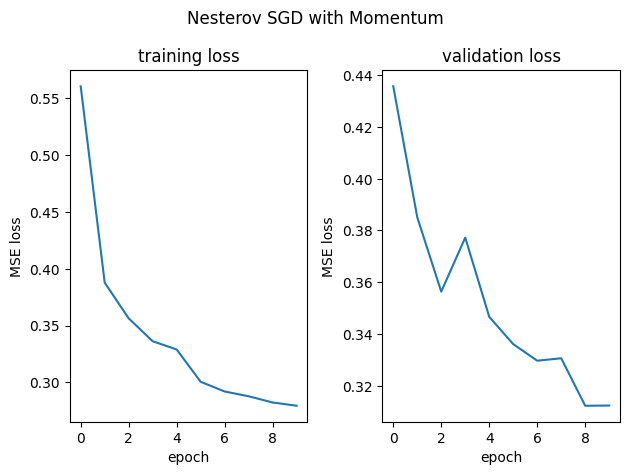

Optimizer: Nesterov SGD with Momentum with learning rate: 0.005 and scheduler: CosineAnnealingLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.5582456098193616
Validation loss for epoch: 0.4227)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.38238041816625445
Validation loss for epoch: 0.4081)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.3553061752983954
Validation loss for epoch: 0.3617)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.34028167214936916
Validation loss for epoch: 0.3379)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.3214741638836871
Validation loss for epoch: 0.3649)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.31114181139366287
Vali

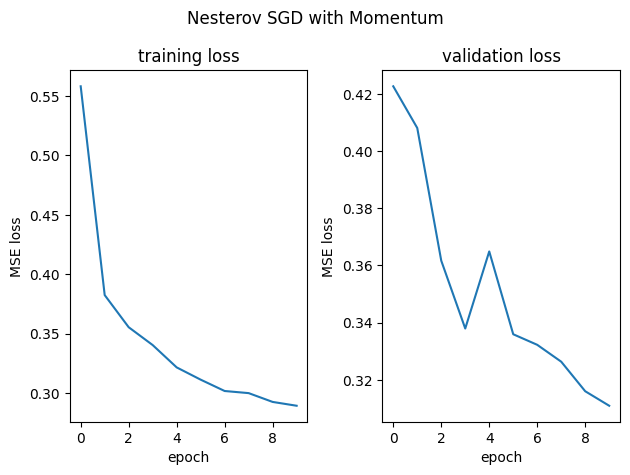

Optimizer: Nesterov SGD with Momentum with learning rate: 0.005 and scheduler: CosineAnnealingWarmRestarts 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.5884427454124773
Validation loss for epoch: 0.4024)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.3672499233213937
Validation loss for epoch: 0.3814)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.34704644303867777
Validation loss for epoch: 0.3466)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.3263323607203443
Validation loss for epoch: 0.3533)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.3126661462824693
Validation loss for epoch: 0.3738)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.3027942479975

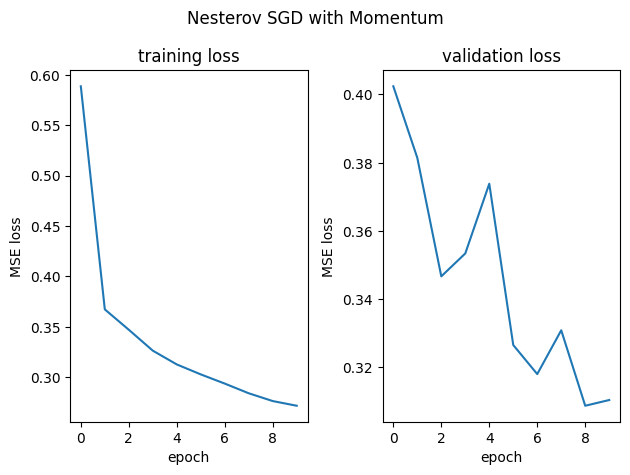

Optimizer: RMSProp with learning rate: 0.005 and scheduler: StepLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 12.482507226164493
Validation loss for epoch: 0.4482)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.39854642420809355
Validation loss for epoch: 0.4033)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.3866452746653715
Validation loss for epoch: 0.7981)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.37187897382650226
Validation loss for epoch: 0.3654)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.3417802943592578
Validation loss for epoch: 0.4318)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.3177847473560709
Validation loss for epoch: 0.3728)


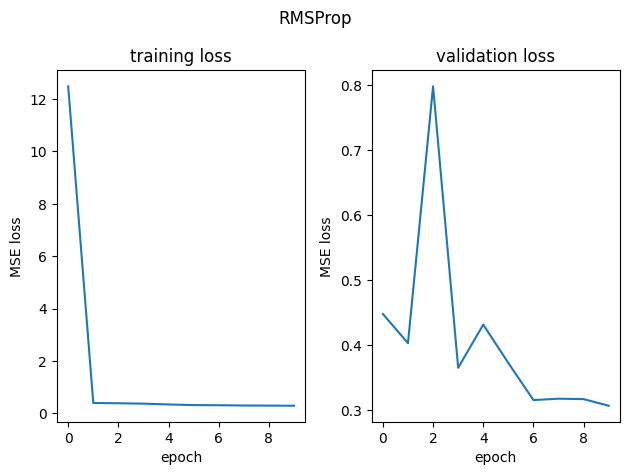

Optimizer: RMSProp with learning rate: 0.005 and scheduler: MultiStepLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 5.19691930447532
Validation loss for epoch: 0.4782)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.461331765769066
Validation loss for epoch: 0.3888)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.39073510830645014
Validation loss for epoch: 0.3627)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.3627484551573222
Validation loss for epoch: 0.3737)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.33497842730937805
Validation loss for epoch: 0.3734)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.2909545520139215
Validation loss for epoch: 0.3142

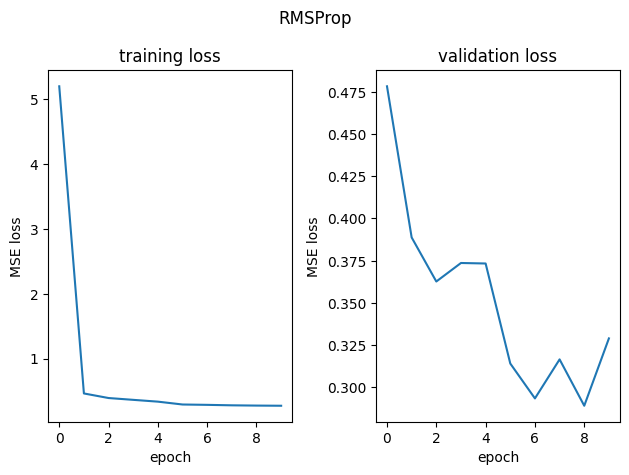

Optimizer: RMSProp with learning rate: 0.005 and scheduler: CosineAnnealingLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 4.079473200493155
Validation loss for epoch: 0.4470)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.4148304315893787
Validation loss for epoch: 0.4549)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.4301077861141051
Validation loss for epoch: 0.3631)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.3575213233717775
Validation loss for epoch: 0.3791)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.33391794984319567
Validation loss for epoch: 0.3263)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.32199738819185086
Validation loss for epoch

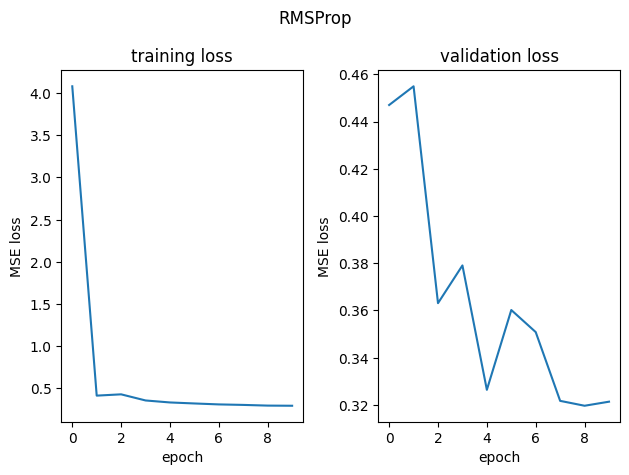

Optimizer: RMSProp with learning rate: 0.005 and scheduler: CosineAnnealingWarmRestarts 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 4.013776709976713
Validation loss for epoch: 0.5755)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.4057731386933443
Validation loss for epoch: 0.3839)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.417187481624099
Validation loss for epoch: 0.5702)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.3464322796305724
Validation loss for epoch: 0.3619)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.32376625059188996
Validation loss for epoch: 0.3601)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.29869779260351065
Validation loss 

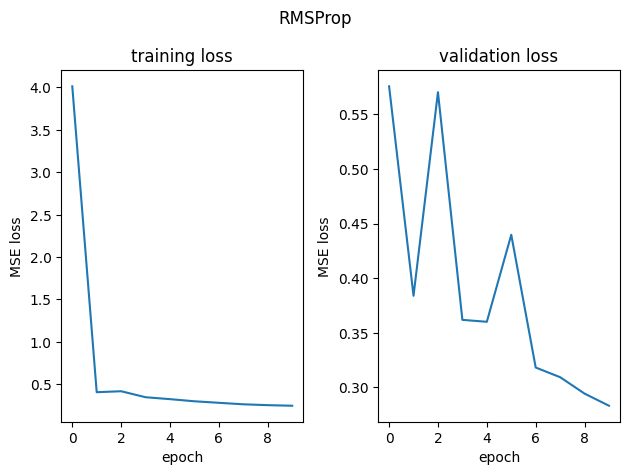

Optimizer: Adam with learning rate: 0.005 and scheduler: StepLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.5060034941189584
Validation loss for epoch: 0.3928)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.3909877910221045
Validation loss for epoch: 0.3450)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.3365057851888437
Validation loss for epoch: 0.3327)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.3436236921368183
Validation loss for epoch: 0.3570)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.3253457870631091
Validation loss for epoch: 0.3096)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.3077555898478073
Validation loss for epoch: 0.3306)

----

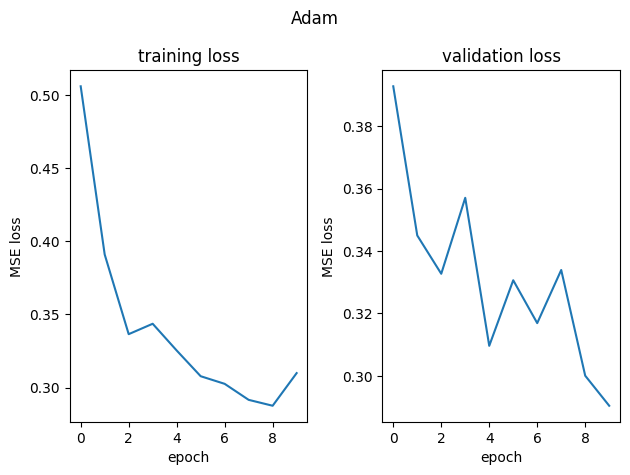

Optimizer: Adam with learning rate: 0.005 and scheduler: MultiStepLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.49670042058007907
Validation loss for epoch: 0.3684)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.501659517745133
Validation loss for epoch: 0.3931)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.3758030234119006
Validation loss for epoch: 0.3745)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.32646416093066205
Validation loss for epoch: 0.3452)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.3249073811040252
Validation loss for epoch: 0.3198)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.31658937806774556
Validation loss for epoch: 0.3094

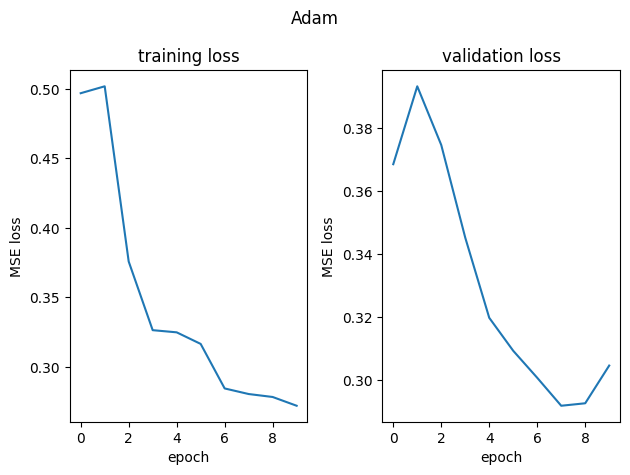

Optimizer: Adam with learning rate: 0.005 and scheduler: CosineAnnealingLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.5146856513204037
Validation loss for epoch: 0.4072)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.3734826451678455
Validation loss for epoch: 0.4275)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.37017708514050573
Validation loss for epoch: 0.3626)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.32155726988494926
Validation loss for epoch: 0.3226)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.31392170096525046
Validation loss for epoch: 0.3520)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.3827700341796189
Validation loss for epoch:

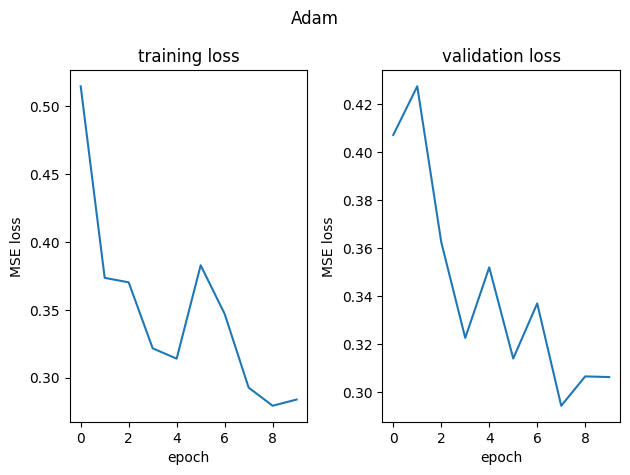

Optimizer: Adam with learning rate: 0.005 and scheduler: CosineAnnealingWarmRestarts 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.5075002889915378
Validation loss for epoch: 0.3902)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.37404456953888976
Validation loss for epoch: 0.3803)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.47515438569594276
Validation loss for epoch: 0.3996)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.33803179616157986
Validation loss for epoch: 0.3365)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.3110109773687029
Validation loss for epoch: 0.3199)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.3021114652036829
Validation loss 

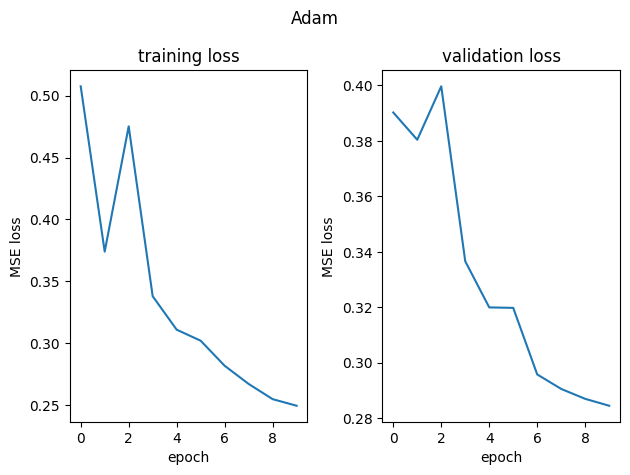

Optimizer: SGD with learning rate: 0.01 and scheduler: StepLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.739242934086154
Validation loss for epoch: 0.5153)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.4626917994490503
Validation loss for epoch: 0.4520)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.41210326064476926
Validation loss for epoch: 0.4320)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.39048888742000654
Validation loss for epoch: 0.4189)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.3730214587453983
Validation loss for epoch: 0.4141)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.36112800304802645
Validation loss for epoch: 0.3880)

----

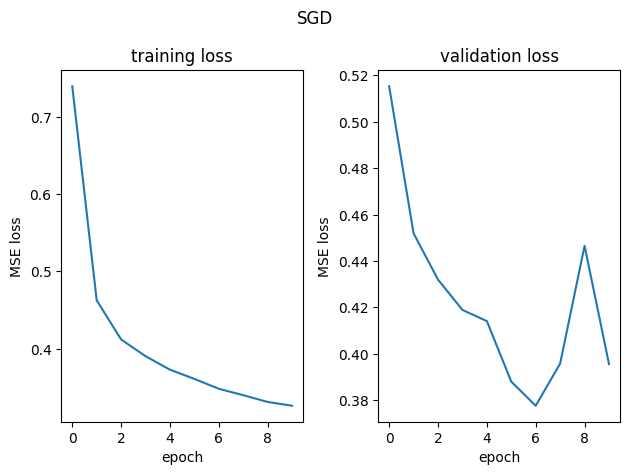

Optimizer: SGD with learning rate: 0.01 and scheduler: MultiStepLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.6933858421326211
Validation loss for epoch: 0.4893)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.437942409723074
Validation loss for epoch: 0.4492)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.40659785593769193
Validation loss for epoch: 0.4525)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.38699200630715463
Validation loss for epoch: 0.4073)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.3727465146509683
Validation loss for epoch: 0.3907)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.35634230380564663
Validation loss for epoch: 0.4056)


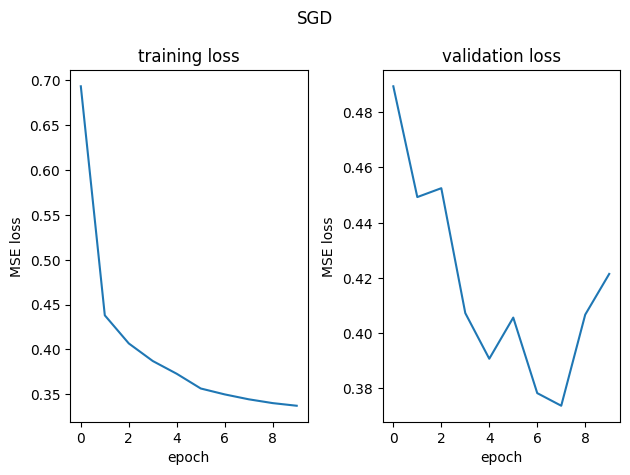

Optimizer: SGD with learning rate: 0.01 and scheduler: CosineAnnealingLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.7641007145784334
Validation loss for epoch: 0.4677)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.41926216800590005
Validation loss for epoch: 0.4268)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.39210611708725973
Validation loss for epoch: 0.4108)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.3761591822139721
Validation loss for epoch: 0.3961)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.3633770804555543
Validation loss for epoch: 0.3787)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.35260961917682293
Validation loss for epoch: 0

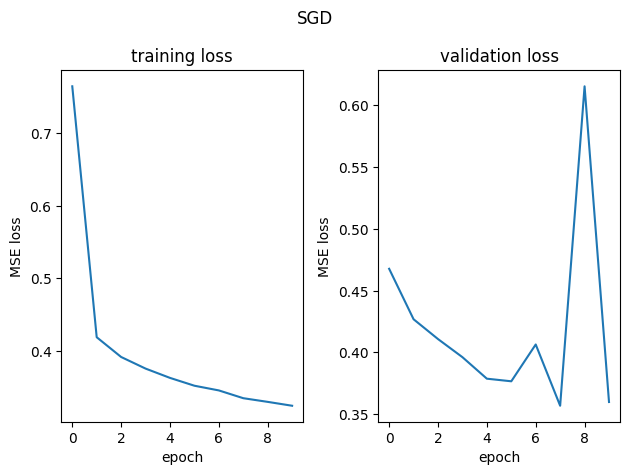

Optimizer: SGD with learning rate: 0.01 and scheduler: CosineAnnealingWarmRestarts 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.8734989154391584
Validation loss for epoch: 0.4927)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.426633098467657
Validation loss for epoch: 0.4283)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.39332111494665123
Validation loss for epoch: 0.4149)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.3800920986001734
Validation loss for epoch: 0.3974)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.36198915349962435
Validation loss for epoch: 0.3992)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.3507770379856888
Validation loss for 

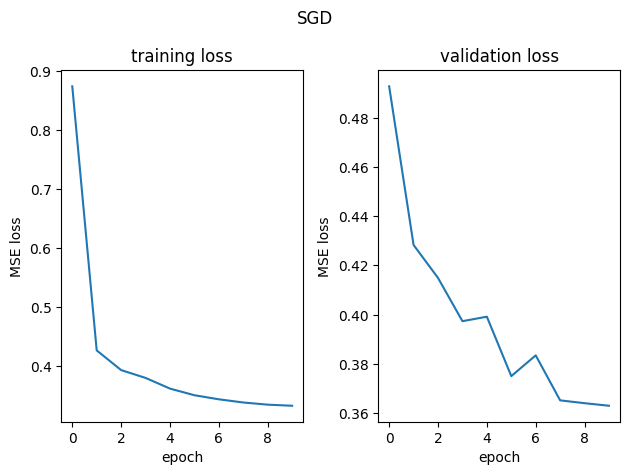

Optimizer: SGD with Momentum with learning rate: 0.01 and scheduler: StepLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.569179801616521
Validation loss for epoch: 0.4154)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.39673585388644605
Validation loss for epoch: 0.3930)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.36248382868294693
Validation loss for epoch: 0.3638)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.34670311430123
Validation loss for epoch: 0.3651)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.33513229409545925
Validation loss for epoch: 0.3921)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.3218706071673505
Validation loss for epoch: 0

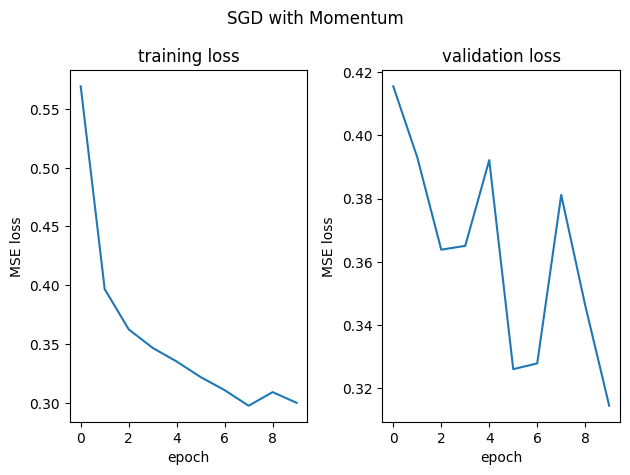

Optimizer: SGD with Momentum with learning rate: 0.01 and scheduler: MultiStepLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.6045042714186474
Validation loss for epoch: 0.4559)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.4095691474138108
Validation loss for epoch: 0.4034)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.37587384647170524
Validation loss for epoch: 0.3903)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.3466413128725459
Validation loss for epoch: 0.3427)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.3307228894261396
Validation loss for epoch: 0.3340)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.2952264185368487
Validation loss for ep

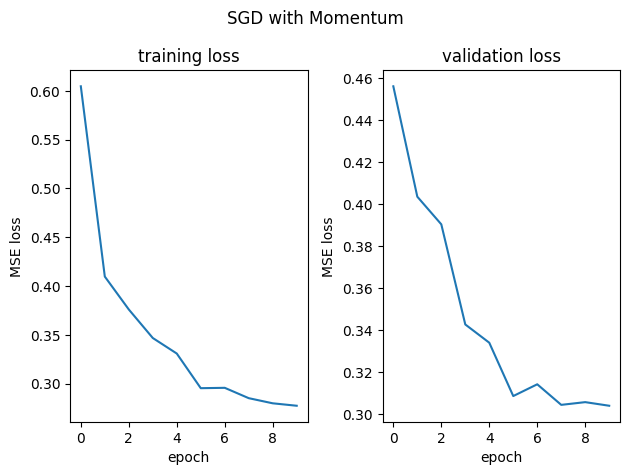

Optimizer: SGD with Momentum with learning rate: 0.01 and scheduler: CosineAnnealingLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) nan
Validation loss for epoch: nan)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) nan
Validation loss for epoch: nan)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) nan
Validation loss for epoch: nan)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) nan
Validation loss for epoch: nan)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) nan
Validation loss for epoch: nan)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) nan
Validation loss for epoch: nan)

-------------------- Epoch 6 --------------------
Average Training Loss for epoch(over al

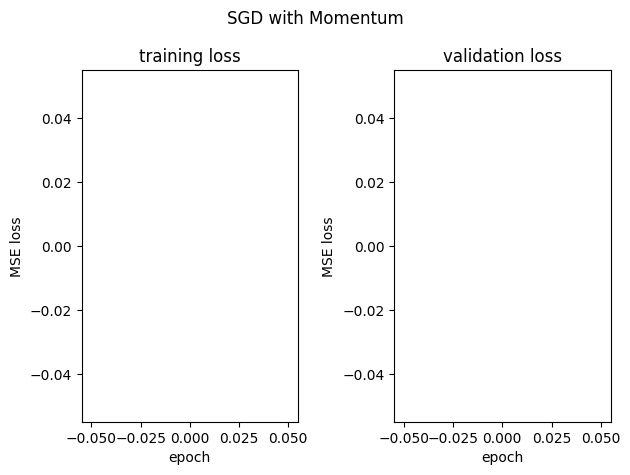

Optimizer: SGD with Momentum with learning rate: 0.01 and scheduler: CosineAnnealingWarmRestarts 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 1.0280581866349794
Validation loss for epoch: 0.4341)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) nan
Validation loss for epoch: nan)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) nan
Validation loss for epoch: nan)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) nan
Validation loss for epoch: nan)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) nan
Validation loss for epoch: nan)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) nan
Validation loss for epoch: nan)

-------------------- Epoch 6 --------------------
Average Tra

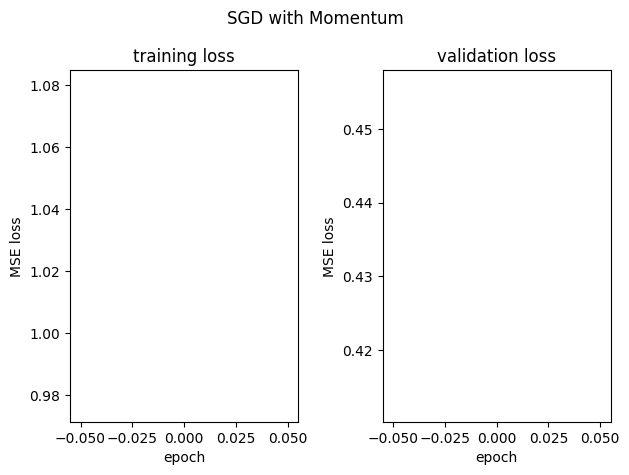

Optimizer: Nesterov SGD with Momentum with learning rate: 0.01 and scheduler: StepLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.5388676329985657
Validation loss for epoch: 0.4112)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.38191566555307505
Validation loss for epoch: 0.3641)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.3757659633998322
Validation loss for epoch: 0.3990)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) nan
Validation loss for epoch: nan)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) nan
Validation loss for epoch: nan)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) nan
Validation loss for epoch: nan)

-------------------- Epoch 6 -------

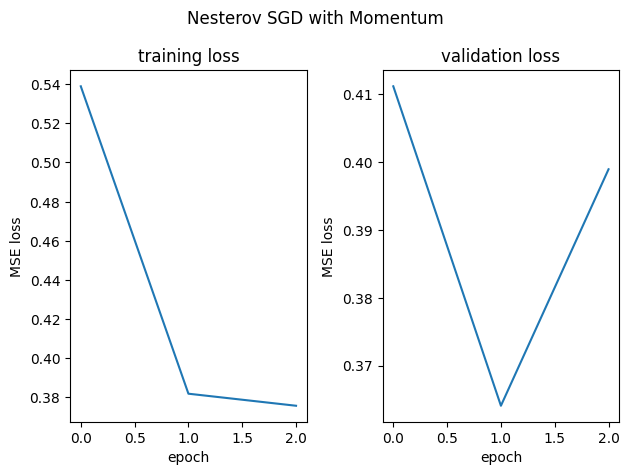

Optimizer: Nesterov SGD with Momentum with learning rate: 0.01 and scheduler: MultiStepLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.5078327742660731
Validation loss for epoch: 0.4055)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.3977347798975168
Validation loss for epoch: 0.4053)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.4384585237872284
Validation loss for epoch: 0.3667)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.3643149154804713
Validation loss for epoch: 0.3880)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.33792217621431414
Validation loss for epoch: 0.3406)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.29974323092440586
Validation l

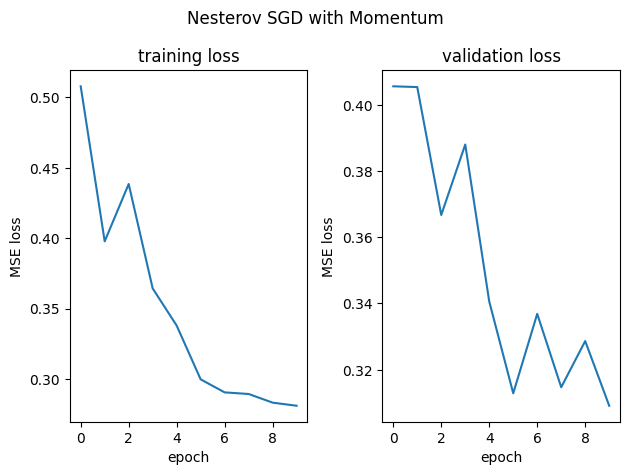

Optimizer: Nesterov SGD with Momentum with learning rate: 0.01 and scheduler: CosineAnnealingLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.5475114462649928
Validation loss for epoch: 0.4004)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.4985006352705238
Validation loss for epoch: 0.4118)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) nan
Validation loss for epoch: nan)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) nan
Validation loss for epoch: nan)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) nan
Validation loss for epoch: nan)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) nan
Validation loss for epoch: nan)

-------------------- Epoch 6 ---------------

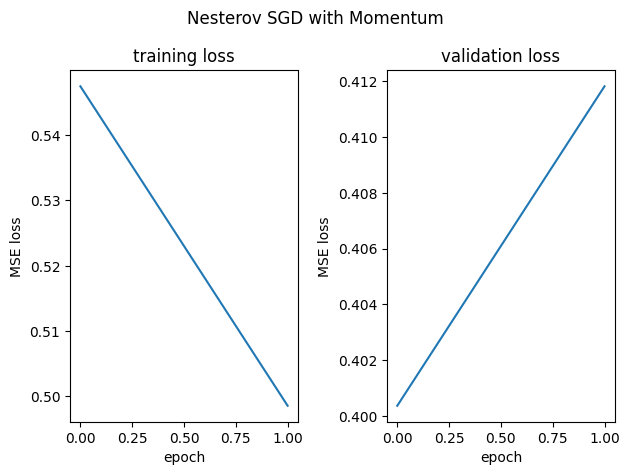

Optimizer: Nesterov SGD with Momentum with learning rate: 0.01 and scheduler: CosineAnnealingWarmRestarts 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.5076355305129447
Validation loss for epoch: 0.6762)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.39931414278009825
Validation loss for epoch: 0.4380)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.3508069576382373
Validation loss for epoch: 0.3501)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.3248359009260889
Validation loss for epoch: 0.3641)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.30800496229687624
Validation loss for epoch: 0.3251)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.2967184201146

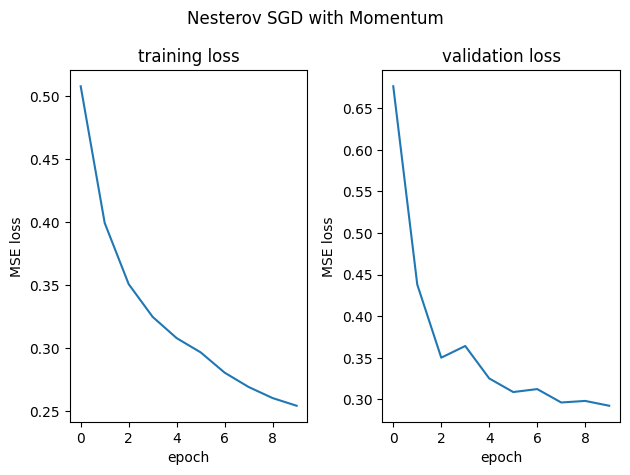

Optimizer: RMSProp with learning rate: 0.01 and scheduler: StepLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 73.49845489526612
Validation loss for epoch: 0.4598)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.4306733493025588
Validation loss for epoch: 0.4591)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.4573510381170606
Validation loss for epoch: 0.4007)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.42063557106045496
Validation loss for epoch: 0.4937)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.3744808481923774
Validation loss for epoch: 0.3729)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.34993342418981865
Validation loss for epoch: 0.3647)

-

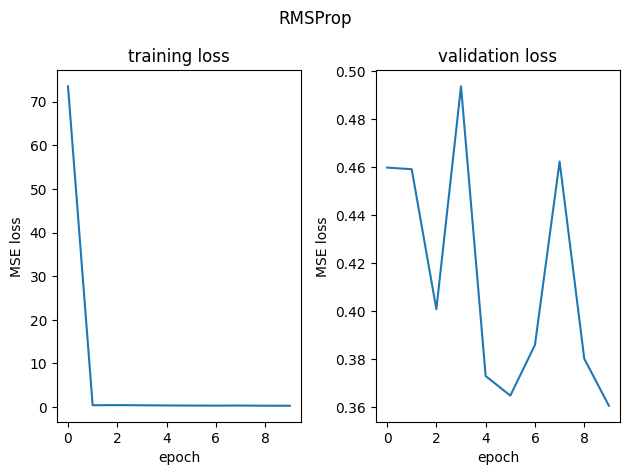

Optimizer: RMSProp with learning rate: 0.01 and scheduler: MultiStepLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 176.865012873129
Validation loss for epoch: 0.6296)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.4823717491750696
Validation loss for epoch: 0.4321)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.50034058247322
Validation loss for epoch: 0.3920)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.42202758072026536
Validation loss for epoch: 0.3923)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.37300384794650354
Validation loss for epoch: 0.3566)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.3199763491387125
Validation loss for epoch: 0.3928)


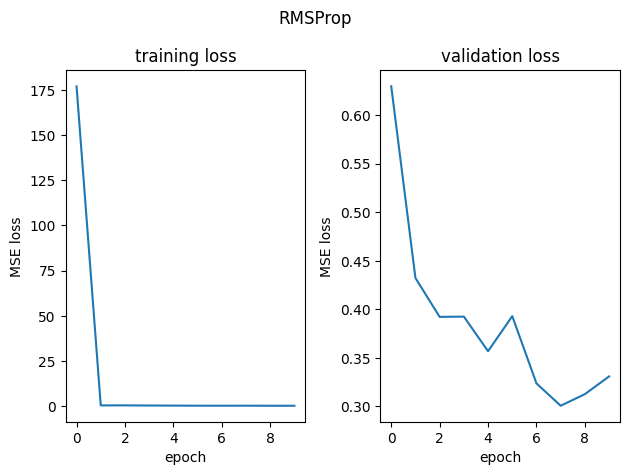

Optimizer: RMSProp with learning rate: 0.01 and scheduler: CosineAnnealingLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 391.75099032395315
Validation loss for epoch: 0.4105)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.4431108811095489
Validation loss for epoch: 0.4216)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.41116151124634576
Validation loss for epoch: 0.3874)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.39383619066031106
Validation loss for epoch: 0.3787)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.43539713237401656
Validation loss for epoch: 0.4213)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.3477777749860445
Validation loss for epoc

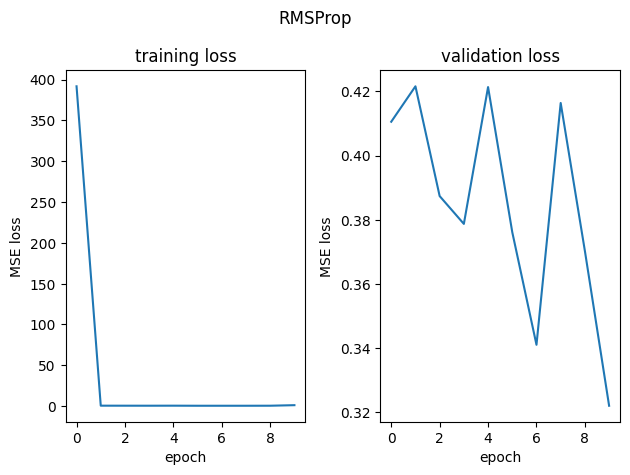

Optimizer: RMSProp with learning rate: 0.01 and scheduler: CosineAnnealingWarmRestarts 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 117.52330357248408
Validation loss for epoch: 0.4027)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.4120747937565356
Validation loss for epoch: 0.3722)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.40922912991548005
Validation loss for epoch: 0.4203)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.37924408958812733
Validation loss for epoch: 0.3511)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.3478341470678559
Validation loss for epoch: 0.3696)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.31941487442339417
Validation los

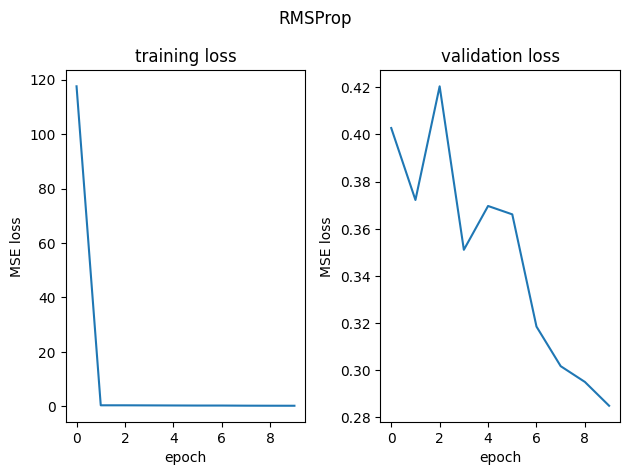

Optimizer: Adam with learning rate: 0.01 and scheduler: StepLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.5750642595235753
Validation loss for epoch: 0.4228)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.3729097531465566
Validation loss for epoch: 0.4323)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.3638258787053349
Validation loss for epoch: 0.3456)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.40695177742271826
Validation loss for epoch: 0.3684)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.32542428751764574
Validation loss for epoch: 0.3454)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.3230785848820104
Validation loss for epoch: 0.3487)

---

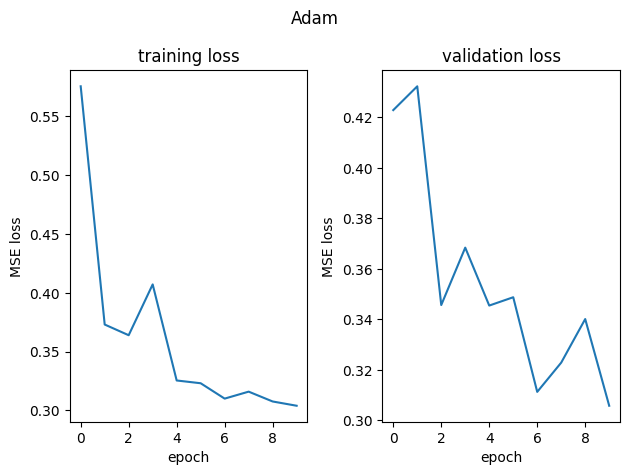

Optimizer: Adam with learning rate: 0.01 and scheduler: MultiStepLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.6758649493938527
Validation loss for epoch: 0.4034)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.37991482505690205
Validation loss for epoch: 0.3982)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.34805793763525716
Validation loss for epoch: 0.3351)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.3407749579147955
Validation loss for epoch: 0.3667)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.3290381094160597
Validation loss for epoch: 0.3495)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.29280265086058493
Validation loss for epoch: 0.3130

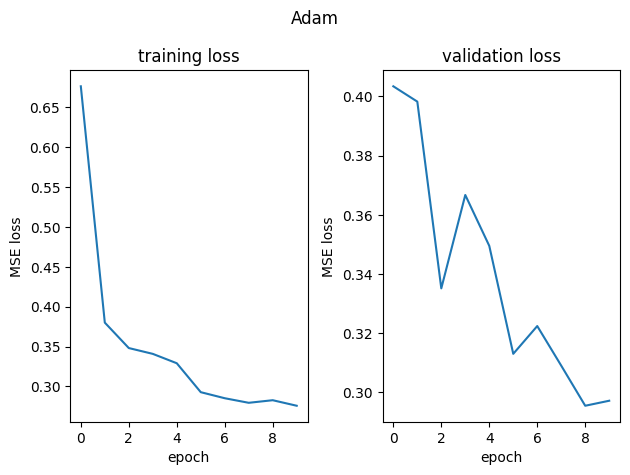

Optimizer: Adam with learning rate: 0.01 and scheduler: CosineAnnealingLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.6441472537683702
Validation loss for epoch: 0.3948)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.3723055552691221
Validation loss for epoch: 0.4144)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.3458779156372874
Validation loss for epoch: 0.3460)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.33354904415267234
Validation loss for epoch: 0.3539)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.3259844235515436
Validation loss for epoch: 0.3386)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.30911227506873884
Validation loss for epoch: 0

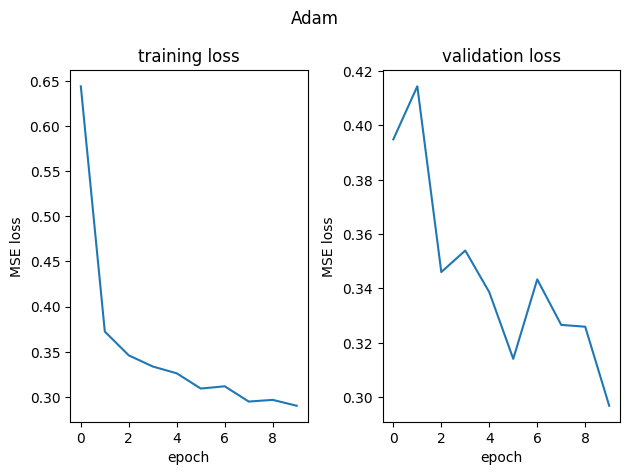

Optimizer: Adam with learning rate: 0.01 and scheduler: CosineAnnealingWarmRestarts 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.5230275660060939
Validation loss for epoch: 0.4171)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.3755792590863673
Validation loss for epoch: 0.4825)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.3543173092689398
Validation loss for epoch: 0.3870)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.3382416569125072
Validation loss for epoch: 0.3830)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.32384213853001065
Validation loss for epoch: 0.3260)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.29660394151521996
Validation loss fo

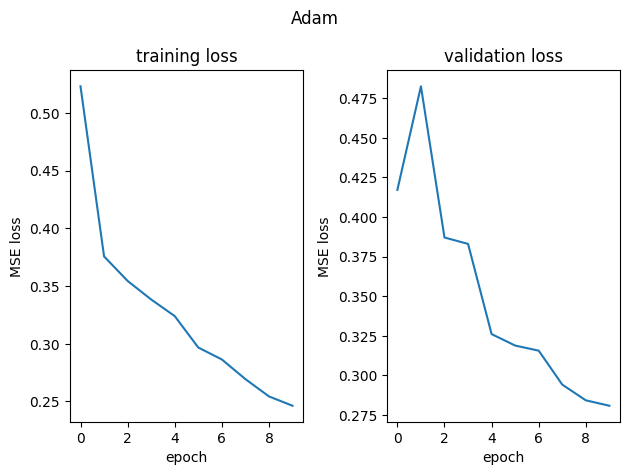

In [22]:
from torch.optim.lr_scheduler import StepLR, MultiStepLR, CosineAnnealingLR, CosineAnnealingWarmRestarts
best_model = NeuralNet_deep_wider() #todo sanity-check if that's true
torch.manual_seed(302); np.random.seed(302) # for safety reasons
lr_rates = [0.001,0.005,0.01]

# todo is this enough variation? should we vary num_epochs?
# todo scheduler params need some rethinking and we should remove a scheduler and an optimizer to reduce compute time
schedulers = {
    'StepLR': lambda optimizer: StepLR(optimizer, step_size=10, gamma=0.5),
    'MultiStepLR': lambda optimizer: MultiStepLR(optimizer, milestones=[5, 20, 40], gamma=0.5),
    'CosineAnnealingLR': lambda optimizer: CosineAnnealingLR(optimizer, T_max=50),
    'CosineAnnealingWarmRestarts': lambda optimizer: CosineAnnealingWarmRestarts(optimizer, T_0=10),
}

for lr in lr_rates:
    optimizers = {
        'SGD': lambda params: torch.optim.SGD(params, lr=lr, momentum=0),
        'SGD with Momentum': lambda params: torch.optim.SGD(params, lr=lr, momentum=0.9),
        'Nesterov SGD with Momentum': lambda params: torch.optim.SGD(params, lr=lr, momentum=0.9, nesterov=True),
        'RMSProp': lambda params: torch.optim.RMSprop(params, lr=lr),
        'Adam': lambda params: torch.optim.Adam(params, lr=lr)
    }
    # optimizers = {
    #     'Adam': lambda params: torch.optim.Adam(params, lr=lr)
    # }

    for optimizer_name, optimizer_init_fn in optimizers.items():
        for scheduler_name, scheduler_init_fn in schedulers.items():
            model = best_model
            model.to(device)
            # reinstantiating should reset optimizer parameters
            optimizer = optimizer_init_fn(model.parameters())
            scheduler = scheduler_init_fn(optimizer)

            print(f'Optimizer: {optimizer_name} with learning rate: {lr} and scheduler: {scheduler_name} \n')
            train_loss, val_loss = train_model(model, train_loader, val_loader, device, optimizer=optimizer, num_epochs=10, scheduler=scheduler)
            # val_accuracies_per_optimizer[optimizer_name] = val_accuracies[-1] # save the last accuracy
            print('-'*50)
            fig,axs = plt.subplots(1,2,layout="tight")
            axs[0].plot(train_loss)
            axs[0].set_title("training loss")
            axs[0].set_xlabel("epoch")
            axs[0].set_ylabel("MSE loss")

            axs[1].plot(val_loss)
            axs[1].set_title("validation loss")
            axs[1].set_xlabel("epoch")
            axs[1].set_ylabel("MSE loss")
            plt.suptitle(f"{optimizer_name}")
            plt.show()
            # reset model and optimizer https://www.youtube.com/watch?v=r9tOQ6EKS1Y&ab_channel=deeplizard
            for layer in model.children():
                layer.reset_parameters()




## d) Final Training with best parameters

In [26]:
final_training_model = NeuralNet_deep_wider()
final_X_train = torch.concatenate((X_train_torch, X_validation_torch))
final_y_train = torch.concatenate((y_train_torch, y_validation_torch))

final_optimizer = ...
final_scheduler = ...



KeyboardInterrupt: 

## f) Binary Classification